<a id="1.2"></a>
    
# **Cars 4 You: Expediting Car Evaluations with ML <font>**

# Group 66

**Daniel de Amorim Rocha** (20221895)  
**Guilherme Tavares da Silva** (20221910)  
**Maria Silvestre de Carvalho** (20221953)  

## GitHub Repository
[Repository link text](https://github.com/guilhermetnsilva/group66-cars4you-regression)

## Group contribution

**Daniel de Amorim Rocha:** WRITE_HERE (main focus + what they did)  
**Guilherme Tavares da Silva:** WRITE_HERE  
**Maria Silvestre de Carvalho:** WRITE_HERE   

**Overall statement:** WRITE_HERE (e.g., collaboration note + final % split)

**Final split:**  
- Student 1 Name: 25%  
- Student 2 Name: 25%  
- Student 3 Name: 25%  



## Table of Contents

- [1. Importing the datasets and libraries](#1-importing-the-datasets-and-libraries)
- [2. EDA & Data cleaning](#2-eda--data-cleaning)
  - [2.1. Descriptive statistics](#21-descriptive-statistics)
  - [2.2. Data cleaning](#22-data-cleaning)
    - [2.2.1. Numerical inconsistencies](#221-numerical-inconsistencies)
    - [2.2.2. Categorical inconsistencies](#222-categorical-inconsistencies)
    - [2.2.3. Duplicates](#223-duplicates)
    - [2.2.4. Missing values](#224-missing-values)
  - [2.3. Data visualization](#23-data-visualization)
    - [2.3.1. Univariate exploration](#231-univariate-exploration)
    - [2.3.2. Multidimensional exploration](#232-multidimensional-exploration)
- [3. Feature Engineering](#3-feature-engineering)
- [4. Split using K-fold Cross-Validation](#4-split-using-k-fold-cross-validation)
- [5. Model Benchmarking](#5-model-benchmarking)
  - [5.1. Common baseline pipeline](#51-common-baseline-pipeline)
  - [5.2. Benchmark](#52-benchmark)
- [6. Model Optimization](#6-model-optimization)
  - [6.1. Feature selection strategies](#61-feature-selection-strategies)
  - [6.2. Random search](#62-random-search)
    - [6.2.1. HistGBR](#621-histgbr)
    - [6.2.2. GBR](#622-gbr)
    - [6.2.3. Random Forest](#623-random-forest)
- [7. Final Model & Kaggle submission](#7-final-model--kaggle-submission)
- [8. Feature Importances](#8-feature-importances)


## Abstract
This project addresses the problem of predicting used car prices for the **Cars4you online marketplace**.  Setting a price for the negociation of cars needs accurate and consistent pricing, both for user trust and for platform revenue. Using data from the 2020 database with vehicle, usage and fuel characteristics, our goal was to build a regression model that is accurate, robust, interpretable, and ready to be deployed.

We started with **exploratory data analysis** followed by **data cleaning**, which included solving inconsistencies,normalizing and correcting brand/model names, transmission and fuel type categories, and finally the assessement of missing values and duplicates. We **engineered additional features** such as car age and usage intensity (mileage per year), applied log transformations on highly skewed variables, which included modelling the target on a log-price scale. All preprocessing steps (categorical encoding, winsorization of extreme values, imputation, scaling and feature selection) were **embedded inside a custom cross-validation pipeline** to avoid data leakage.

We benchmarked several regression families (linear models, KNN, Decision Tree, bagging and boosting ensembles, neural networks), using **MAE and R²** as primary metrics under **K-fold cross-validation**. Tree-based ensembles, in particular Hist Gradient Boosting, Gradient Boosting and Random Forest, clearly outperformed other tested models. We then performed targeted hyperparameter tuning via manual random search and compared alternative feature selection strategies (filter, wrapper and embedded methods) to select a final pipeline. The best model achieved a substantial reduction in validation MAE compared to simpler baselines.

In the open-ended component, we implemented a Streamlit interface that allows end users to simulate new listings and obtain model-based price suggestions, and we used feature importance and SHAP analyses to understand which variables drive price predictions and whether the learned patterns are economically plausible. Together, these elements provide an end-to-end, deployable and interpretable pricing solution for Cars4you.

## I. Identifying Business Needs

Cars4you is an online marketplace for used cars, where pricing decisions directly affect both conversion rates and the perceived fairness of the platform. If similar vehicles are listed at very different prices, sellers may lose trust in the system and buyers may either overpay or defect to competitors. At the same time, manual pricing does not scale well when thousands of listings are created every day.

The goal of this project is to build a data-driven pricing model that can suggest realistic market prices for new listings, given information about the car (brand, model, age, mileage, fuel type, etc.). From a business perspective, the model should (i) reduce obvious under- and over-pricing, (ii) be stable enough to generalise to new cars, and (iii) be interpretable enough for product and business teams to understand why a given price is suggested.

From a technical perspective, we frame the problem as a supervised regression task on tabular data. All steps of preprocessing (cleaning, encoding, winsorization, feature engineering, scaling and feature selection) are implemented inside a custom cross-validation pipeline to avoid data leakage. Model assessment is based on K-fold cross-validation with 3 folds on the training data, using MAE as the main performance metric (with RMSE and R² as complementary diagnostics). The held-out Kaggle test set is used only once at the end, to generate the final CSV submission with our best model.

<a id="1.1"></a>
    
# **Metadata <font>**

| **Attribute**      | **Description** |
|--------------------|-----------------|
| `carID`            | An attribute that contains an identifier for each car. |
| `Brand`            | The car’s main brand (e.g., Ford, Toyota). |
| `model`            | The car model. |
| `year`             | The year of registration of the car. |
| `mileage`          | The total reported distance travelled by the car (in miles). |
| `tax`              | The amount of road tax (in £) that, in 2020, was applicable to the car in question. |
| `fuelType`         | Type of fuel used by the car (Diesel, Petrol, Hybrid, Electric). |
| `mpg`              | Average Miles per Gallon. |
| `engineSize`       | Size of engine in liters (cubic decimeters). |
| `paintQuality%`    | Mechanic’s assessment of overall paint quality and hull integrity (filled during evaluation). |
| `previousOwners`   | Number of previous registered owners of the vehicle. |
| `hasDamage`        | Boolean marker filled by the seller at registration stating whether the car is damaged or not. |
| `price` *(train only)* | The car’s price when purchased by Cars 4 You (in £). |

<a id="1.1"></a>
    
# **1. Importing datasets and libraries <font>**

This section, as mentioned in the title, is intended for importing the data and necessary libraries.

In [5]:
import pandas as pd
import numpy as np
import random

#data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# fuzzy matching for category correction
from thefuzz import process, fuzz

# set up of cross validation functions
from sklearn.base import clone
from collections import Counter

# model selection
from sklearn.model_selection import KFold

# scaling
from sklearn.preprocessing import RobustScaler

# feature selection
from sklearn.feature_selection import SelectKBest, mutual_info_regression, SelectFromModel, RFE

# models to try
from sklearn.linear_model import Ridge, HuberRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor, BaggingRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

# metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# to export the model and 8. Feature Importance
import joblib

import shap

# Make the project root importable so that we can do `from src...`
import sys
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.data_loading import load_raw_data
from src.modeling import run_model, transform_X, evaluate_model, avg_scores, predict_on_test


In [6]:
train_data, test_data = load_raw_data()

<a id="1"></a>

# **2. EDA & Data cleaning <font>**

### II.1. Data overview and key insights

We started by exploring the raw training and test set provided by Cars4you, which contains one row per car listing and a mix of numerical and categorical features. The core numerical variables include the advertised price, mileage, engine size, fuel efficiency (mpg) and annual tax, while the main categorical variables capture brand, model, fuel type and transmission, together with registration year and previous owners. Additionally, it is to note that paintQuality% should be excluded from the dataset, as it depends on the mechanics assessment.

The initial exploration highlighted several issues that have a direct impact on modelling:

- **Heavy skewness and outliers** in price, mileage, tax and mpg, with a long right tail of very expensive or extreme cars.
- **Strong non-linear patterns** between price and continuous features such as mileage and age, suggesting that simple linear models would struggle without transformations.
- **High-cardinality categorical variables**, especially `Brand` and `model`, with many near-duplicate or noisy categories (typos, inconsistent capitalisation, truncated names).
- **Missing values** scattered across both numerical and categorical features, and a small number of clearly problematic text entries (e.g. placeholder strings instead of real values).

These patterns motivated the preprocessing pipeline described next, which was designed to make the data more homogeneous, reduce the influence of extreme values and expose more meaningful signals to the models, while keeping everything compatible with cross-validation.

In [7]:
display(train_data.info())
display(test_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75973 entries, 0 to 75972
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           75973 non-null  int64  
 1   Brand           74452 non-null  object 
 2   model           74456 non-null  object 
 3   year            74482 non-null  float64
 4   price           75973 non-null  int64  
 5   transmission    74451 non-null  object 
 6   mileage         74510 non-null  float64
 7   fuelType        74462 non-null  object 
 8   tax             68069 non-null  float64
 9   mpg             68047 non-null  float64
 10  engineSize      74457 non-null  float64
 11  paintQuality%   74449 non-null  float64
 12  previousOwners  74423 non-null  float64
 13  hasDamage       74425 non-null  float64
dtypes: float64(8), int64(2), object(4)
memory usage: 8.1+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32567 entries, 0 to 32566
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   carID           32567 non-null  int64  
 1   Brand           31918 non-null  object 
 2   model           31917 non-null  object 
 3   year            31914 non-null  float64
 4   transmission    31944 non-null  object 
 5   mileage         31878 non-null  float64
 6   fuelType        31911 non-null  object 
 7   tax             29259 non-null  float64
 8   mpg             29279 non-null  float64
 9   engineSize      31939 non-null  float64
 10  paintQuality%   31942 non-null  float64
 11  previousOwners  31970 non-null  float64
 12  hasDamage       31970 non-null  float64
dtypes: float64(8), int64(1), object(4)
memory usage: 3.2+ MB


None

The training dataset has 75973 cars and the test has 32 566.

In [8]:
train_data.shape

(75973, 14)

In [9]:
display(train_data.head())

carID   Brand      model    year  price transmission  mileage fuelType  \
0  69512      VW       Golf  2016.0  22290    Semi-Auto  28421.0   Petrol   
1  53000  Toyota      Yaris  2019.0  13790       Manual   4589.0   Petrol   
2   6366    Audi         Q2  2019.0  24990    Semi-Auto   3624.0   Petrol   
3  29021    Ford     FIESTA  2018.0  12500        anual   9102.0   Petrol   
4  10062     BMW   2 Series  2019.0  22995       Manual   1000.0   Petrol   

     tax        mpg  engineSize  paintQuality%  previousOwners  hasDamage  
0    NaN  11.417268         2.0           63.0        4.000000        0.0  
1  145.0  47.900000         1.5           50.0        1.000000        0.0  
2  145.0  40.900000         1.5           56.0        4.000000        0.0  
3  145.0  65.700000         1.0           50.0       -2.340306        0.0  
4  145.0  42.800000         1.5           97.0        3.000000        0.0

In [10]:
train_data.tail(10)

carID     Brand         model    year  price transmission  mileage  \
75963  67221        VW         T-Roc  2020.0  25785    Semi-Auto     10.0   
75964  41090  Mercedes     GLC Class  2016.0  24486          NaN  22955.0   
75965  16023      Ford      EcoSport  2017.0  10498       Manual  13613.0   
75966  60263      Opel   Crossland X  2018.0  13995       Manual   1800.0   
75967  44131  Mercedes     GLC Class  2018.0  30495    Semi-Auto  11943.0   
75968  37194  Mercedes       C Class  2015.0  13498       Manual  14480.0   
75969   6265      Audi            Q3  2013.0  12495    Semi-Auto  52134.0   
75970  54886    Toyota          Aygo  2017.0   8399    Automatic  11304.0   
75971    860      Audi            Q3  2015.0  12990       Manual  69072.0   
75972  15795      Ford        Fiesta  2018.0  10495       Manual  16709.0   

      fuelType    tax       mpg  engineSize  paintQuality%  previousOwners  \
75963   Petrol  145.0  39.80000         1.5           65.0             4.0   
75964   Diesel  125.0  56.50000         2.1           72.0             4.0   
75965   Petrol  125.0  88.32164         1.0           57.0             3.0   
75966   Petrol  150.0  57.70000         1.2           69.0             0.0   
75967   Diesel  150.0  56.50000         2.1           74.0             NaN   
75968    etrol  125.0  53.30000         2.0           78.0             0.0   
75969   Diesel  200.0  47.90000         2.0           38.0             2.0   
75970   Petrol  145.0  67.00000         1.0           57.0             3.0   
75971    iesel  125.0  60.10000         2.0           74.0             2.0   
75972    Petro  145.0  64.20000         1.1           38.0             1.0   

       hasDamage  
75963        0.0  
75964        0.0  
75965        0.0  
75966        0.0  
75967        0.0  
75968        0.0  
75969        0.0  
75970        0.0  
75971        0.0  
75972        0.0

<a id="1"></a>

## **2.1. Descriptive statistics <font>**

Computing the descriptive statistics for the numerical variables.

* The maximun of `year` is 2024.1217, which signals 2 problems: i) it should be an integer with no decimal part, and ii) there should be no cars dated after 2020, as this is a dataset of cars until that year;
* `hasDamage` is always 0.0 in the training data;
* `mileage`, `tax`, `mpg`, `engineSize` and `previousOwners` have a negative minimum;
* `paintQuality%`should be excluded from the dataset.

In [11]:
train_data.describe().T

count          mean           std           min       25%  \
carID           75973.0  37986.000000  21931.660338      0.000000  18993.00   
year            74482.0   2017.096611      2.208704   1970.000000   2016.00   
price           75973.0  16881.889553   9736.926322    450.000000  10200.00   
mileage         74510.0  23004.184088  22129.788366 -58540.574478   7423.25   
tax             68069.0    120.329078     65.521176    -91.121630    125.00   
mpg             68047.0     55.152666     16.497837    -43.421768     46.30   
engineSize      74457.0      1.660136      0.573462     -0.103493      1.20   
paintQuality%   74449.0     64.590667     21.021065      1.638913     47.00   
previousOwners  74423.0      1.994580      1.472981     -2.345650      1.00   
hasDamage       74425.0      0.000000      0.000000      0.000000      0.00   

                    50%      75%            max  
carID           37986.0  56979.0   75972.000000  
year             2017.0   2019.0    2024.121759  
price           14699.0  20950.0  159999.000000  
mileage         17300.0  32427.5  323000.000000  
tax               145.0    145.0     580.000000  
mpg                54.3     62.8     470.800000  
engineSize          1.6      2.0       6.600000  
paintQuality%      65.0     82.0     125.594308  
previousOwners      2.0      3.0       6.258371  
hasDamage           0.0      0.0       0.000000

* `Brand` has 72 unique values, `model` has 735, which might be real numbers, meaning that if these are all real brands and models, the dataset has a huge diversity of vehicles.
* however, `transmission` and `fuelType` have very high cardinality (40 and 34 respectively). It seems unrealistic to exist 40 different types of transmission.

There's a need to further explore the unique values of these categorical features, because there's a high probability of having misspelled or inconsistent categories:

In [12]:
train_data.describe(include='O').T

count unique     top   freq
Brand         74452     72    Ford  14808
model         74456    735   Focus   6353
transmission  74451     40  Manual  38050
fuelType      74462     34  Petrol  37995

We suspect that the variable '`hasDamage`' only has the value 0.0. If this verefies, we should delete it from the dataset.

In [13]:
train_data['hasDamage'].value_counts()

hasDamage
0.0    74425
Name: count, dtype: int64

## 2.2. Data cleaning

We need to create a copy before performing any transformations, to preserve the original version. It is important to note that the preprocessing we are applying here, to remove the inconsistencies, is being applied to both train and test data. We are only applying deterministic changes at this point, to prevent data leakage.

In [14]:
train = train_data.copy()
test = test_data.copy()

Regarding variables that should be excluded from the dataset:
* `hasDamage` only takes the value 0.0 in the train/validation data; it has no relevant information to predict price, therefore it will be removed;
* `paintQuality%` should also be removed, because results from the mechanic's assessment of the overall paint quality. Our model is meant to do predictions based on the user's input, without the mechanic's input on the car's characteristics.

In [15]:
train = train.drop(columns=['hasDamage', 'paintQuality%'], axis = 1)
test = test.drop(columns=['hasDamage', 'paintQuality%'], axis=1)

### 2.1.1. Numerical inconsistencies

**Inconsistencies**

The following list summarizes the inconsisties we searched for and identified, involving the numerical features:
*  **Engine size set to zero** when the car is **not eletric** (note that, even though the categories for `fuelType` are all misspelled, the electric one is the only intact, so we can filter it in this way): assuming these are note real zeros, **set them to Nan** to impute later seems the best approach.
* **Non zero miles per gallon for eletric cars**: in these cases, we will **set mpg to zero**.
* Cars with over 200 miles per gallon: after some research on the regular/usual values for consumption in miles per gallon, we consider all values higher than 200 mpg an error that needs to be corrected. 200 miles per gallon is extremely high for almost any regular car. Therefore we will convert them to **Nan** to later be imputed.
* **Year as a float**: We are going to correct this by **rounding year to the closest integer**.
* Years after 2020:  cars 4 you has provided this data from an older version of the database, from 2020. Therefore, all values after 2020 don't make sense. We assume this was an error and in reality these cars are older than that: we will set them to **Nan** and impute them later.
* negative values in `mileage`, `tax`, `mpg`, `engineSize`, `previousOwners`: this must be an error in data collection, therefore will be replaced by **Nan**.

In [16]:
train[(train['engineSize']==0)& (train['fuelType'] != "Electric")]

carID    Brand      model    year  price transmission  mileage  \
64     30317     Ford        NaN  2019.0   9999       Manual  10000.0   
759    21935     Ford         KA  2018.0   8444       Manual  17000.0   
1039    9518      BMW   2 Series  2015.0  14700    Automatic  32882.0   
1057   32528  Hyundai     Tucson  2016.0  13800       Manual  27311.0   
1519   33804  Hyundai     Tucson  2019.0  15000       Manual  22397.0   
...      ...      ...        ...     ...    ...          ...      ...   
74469  26630     Ford     Fiesta  2018.0  11463          NaN  18000.0   
75168  20128     Ford      Focus  2018.0  18389       Manual  19000.0   
75401  47605    Skoda      Fabia  2018.0  11500       Manual  10720.0   
75405  33307  Hyundai        I10  2018.0   8500       Manual  12948.0   
75940   3890     Audi         Q2  2020.0  24888    Automatic   1500.0   

      fuelType    tax   mpg  engineSize  previousOwners  
64      Petrol  145.0  47.9         0.0             3.0  
759     Petrol  145.0  57.7         0.0             0.0  
1039    Diesel  125.0  60.1         0.0             0.0  
1057    Diesel   30.0  61.7         0.0             1.0  
1519    Petrol  150.0  34.9         0.0             2.0  
...        ...    ...   ...         ...             ...  
74469    Petro  145.0  65.7         0.0             0.0  
75168   Petrol    NaN   NaN         0.0             2.0  
75401   Petrol  150.0  64.2         0.0             4.0  
75405   Petrol  145.0  60.1         0.0             2.0  
75940   Petrol  145.0  42.2         0.0             3.0  

[180 rows x 12 columns]

In [17]:
train.loc[(train['engineSize']==0)& (train['fuelType'] != "Electric"), "engineSize"] = np.nan
test.loc[(test['engineSize']==0)& (test['fuelType'] != "Electric"), "engineSize"] = np.nan

In [18]:
train[(train['mpg'] != 0) & (train['fuelType'] == "Electric")]

carID Brand    model    year  price transmission  mileage  fuelType  \
6978   12786   NaN       i3  2015.0  17400    Automatic  29465.0  Electric   
37023  64169  Opel   Ampera  2015.0  12999    Automatic  34461.0  Electric   
52274  21931  Ford   Mondeo     NaN  15500    Automatic  24531.0  Electric   
52579  16306  Ford   Mondeo  2016.0  15975    automatic   9396.0  Electric   

       tax    mpg  engineSize  previousOwners  
6978   0.0  470.8    3.822758             2.0  
37023  0.0  235.4    1.400000             1.0  
52274  0.0   67.3    2.000000             4.0  
52579  0.0   67.3    2.000000             3.0

In [19]:
train.loc[(train['mpg'] != 0) & (train['fuelType'] == "Electric"), 'mpg'] = 0
test.loc[(test['mpg'] != 0)& (test['fuelType'] == "Electric"), 'mpg'] = 0

In [20]:
train[(train['mpg'] > 200)]

carID     Brand     model    year  price transmission       mileage  \
552    53577    Toyota     PRIUS  2018.0  19072    Automatic  43584.000000   
4101   13075       BMW        i3  2015.0  15498    Automatic  33931.000000   
4191   31699   Hyundai     Ioniq  2018.0  18970    Automatic  14886.000000   
4935   44875  Mercedes   C Class  2020.0  40999    Automatic    400.000000   
5278   12640       BMW        i3  2017.0  19500    Automatic  23956.000000   
7904   55563    Toyota     Prius  2019.0  28590     Automati   5000.000000   
10158  48968     Skoda    Superb  2020.0  29995    Semi-Auto     15.000000   
17247  50564     Skoda    Superb  2020.0  28332    Semi-Auto   5000.000000   
17955  53572    Toyota     Prius  2018.0  22890    Automatic  31786.000000   
18261   8993        BM        i3  2016.0  18999    Automatic   9990.000000   
18710  12853       BMW        i3  2017.0  21898    Automatic  10839.000000   
21445  12090       bmw        i3  2016.0  19490    Automatic   8421.000000   
24746  55203    Toyota     Prius  2019.0  22495    Automatic  13772.000000   
24975  13378       BMW        i3  2015.0  17481    Automatic   9886.000000   
28215  48883     Skoda    Superb  2020.0  29799    Automatic    897.000000   
29581  12269       BMW        i3  2017.0  19980    Automatic  26965.000000   
31953  63830       Ope    Ampera  2014.0  11400    Automatic  64764.000000   
33383  10695       bmw        i3  2017.0  21494    Automatic           NaN   
33829  11532       BMW        i3  2016.0  16500    Automatic  35446.000000   
34200  31790   Hyundai     Ioniq  2019.0  19995    Automatic   7386.000000   
36726   9737       BMW        i3  2014.0  14495     Automati  34539.000000   
38205  53399    Toyota     Prius  2019.0  27999     utomatic   3650.000000   
39175  51387    Toyota     Prius  2020.0  27990    Automatic   1500.000000   
40280   8497       BMW        i3  2017.0  21495    Automatic  24041.000000   
42168  16210      Ford      Kuga  2020.0  31000    Semi-Auto     10.000000   
45755  54503    Toyota     Prius  2019.0  24987    Automatic   6552.000000   
46823  11068       BMW        i3  2016.0  16482          NaN  43695.000000   
48055  13430       BMW        i3  2017.0  19998    Automatic  41146.000000   
48149  14531       BMW        i3  2017.0  18500    Automatic  36429.000000   
48831  47581     Skoda    Superb  2020.0  26795    Automatic   3600.000000   
50071  12332       BMW        i3  2015.0  14285    Automatic  65800.000000   
51287  14512       BMW         i  2017.0  19000     utomatic  23983.000000   
51750  10327       BMW        i3  2014.0  15450    Automatic  42479.000000   
53020  11589       BMW        i3  2016.0  17100    Automatic  25269.000000   
53151  53771    Toyota     Prius  2018.0  19699    Automatic  43678.000000   
54088  17740      FORD      Kuga  2020.0  32995    Automatic     11.000000   
54333  10133       BMW        i3  2017.0  19300     utomatic -58540.574478   
57271  52743    Toyota     Prius  2019.0  29995    Automatic           NaN   
58891  26667      Ford      Kuga  2020.0  32000    Automatic     10.000000   
59959  52742    Toyota     Prius  2019.0  27999    Automatic   9975.000000   
61955  51312    Toyota     Prius  2018.0  18699    Automatic           NaN   
63762   9643       BMW        i3  2017.0  19948    Automatic  20929.000000   
63961  54008    Toyota     PRIUS  2018.0  20495    Automatic  16347.000000   
64601  10967       BMW        i3  2016.0  17000    Automatic  41063.000000   
65453   9815       BMW        i3  2016.0  19875    Automatic  20013.000000   
70578   9196       BMW        I3  2016.0  19850    Automatic  19995.000000   
70584  11962       BMW        i3  2017.0  22495    Automatic  21025.000000   
70837  17558      Ford      Kuga  2020.0  33500    Automatic   5534.000000   
71842  52495    Toyota     Prius  2017.0  20998     Automati  17681.000000   
72900  36609  Mercedes   E Class  2019.0  34995    Automatic   4129.000000   

      fuelType    tax    mpg

In [21]:
train.loc[train['mpg'] > 200, 'mpg'] = np.nan
test.loc[test['mpg'] > 200, 'mpg'] = np.nan

In [22]:
# Round the 'year' column to the nearest integer and convert to integer type
train['year'] = train['year'].round().astype('Int64')
test['year'] = test['year'].round().astype('Int64')

In [23]:
train[train['year']>2020]

carID     Brand       model  year  price transmission  mileage  \
35     53282    Toyota       Yaris  2023  16995       Manual   1225.0   
216    20770      Ford        Kuga  2023  16950       Manual   3376.0   
590    42947  mercedes   GLE Class  2024  54885    Automatic  10516.0   
647    22446      Ford      fiesta  2023  10700       manual   8015.0   
859    11832       BMW          Z4  2024  31350    Automatic    111.0   
...      ...       ...         ...   ...    ...          ...      ...   
73935  22614      Ford        KUGA  2023  13998       MANUAL  32544.0   
74468  75005        VW      Touran  2023  14995      unknown  23746.0   
74591  44569  Mercedes     C Class  2024  22532    Semi-Auto  20150.0   
74900  57384      Opel       Mokka  2023   7299       Manual  56136.0   
75499  60921      Opel         NaN  2023  15499    Automatic  33490.0   

      fuelType    tax   mpg  engineSize  previousOwners  
35      Petrol  145.0  47.9         1.5             0.0  
216     Diesel  145.0  54.3         1.5             1.0  
590     Diesel  145.0   NaN         3.0             4.0  
647     Petrol  145.0  55.4         1.1             1.0  
859     Petrol  145.0  38.7         2.0             1.0  
...        ...    ...   ...         ...             ...  
73935   Diesel  145.0  54.3         2.0             2.0  
74468   Diesel   30.0  65.7         1.6             0.0  
74591    Petro    NaN   NaN         2.0             3.0  
74900   Diesel   30.0  62.8         1.7             4.0  
75499   Diesel  145.0  51.4         2.0             4.0  

[358 rows x 12 columns]

In [24]:
train.loc[train['year'] > 2020, 'year'] = np.nan
test.loc[test['year'] > 2020, 'year'] = np.nan

In [25]:
train[(train["mileage"]< 0) | (train["tax"]< 0) |
           (train["mpg"]< 0) | (train["engineSize"]< 0) |
           (train["previousOwners"]< 0)]

carID     Brand     model  year  price transmission       mileage  \
3      29021      Ford    FIESTA  2018  12500        anual   9102.000000   
26     35263  Mercedes    C Clas  <NA>  11295    Automatic  45000.000000   
126    71677        VW    Tiguan  2019  29999    Semi-Auto    669.000000   
168    46204  Mercedes   C Class  2019  66699    Semi-Auto    630.000000   
268    70615        VW    Tiguan  2020  25000       Manual -48190.655673   
...      ...       ...       ...   ...    ...          ...           ...   
75791  15708      Ford      Focu  2019  16998    Automatic   8703.000000   
75859  55820     oyota      Aygo  2019   8491       Manual -39765.602338   
75883  52251    Toyota     Hilux  2018  22498       Manual -39765.602338   
75912  55591    Toyota      Aygo  2019   8480       Manual   5976.000000   
75915  11534       BMW        X3  2019  33606    Automatic   6527.000000   

      fuelType         tax   mpg  engineSize  previousOwners  
3       Petrol  145.000000  65.7         1.0       -2.340306  
26      Petrol  -56.193202  46.3         1.6             NaN  
126     Diesel  145.000000  39.8         2.0       -2.345650  
168     Petrol  -56.193202  28.5         4.0        2.000000  
268     Petrol  145.000000  38.2         1.5        3.000000  
...        ...         ...   ...         ...             ...  
75791   Petrol  -45.780610  40.9         1.5        0.000000  
75859   Petrol  145.000000  56.5         1.0        0.000000  
75883      NaN  265.000000  40.4         2.4        3.000000  
75912   Petrol  145.000000  56.5         1.0       -2.340102  
75915   Diesel  145.000000  54.3         2.0       -2.312260  

[1226 rows x 12 columns]

In [26]:
columns_to_check = ["mileage", "tax", "mpg", "engineSize", "previousOwners"]

for col in columns_to_check:
    train.loc[train[col] < 0, col] = np.nan
    test.loc[test[col] < 0, col] = np.nan

### 2.1.2. Categorical inconsistencies

**Inconsistencies**:

It is important to take a closer look at the suspicious amount of unique values for `transmission`, `Fuel type`, `Brand` and `model`. There are model names such as "pol" that should be named "polo" from Volkswagen, for example.

In [27]:
# Display unique values for 'transmission'
print("Unique values for Transmission:")
print(train['transmission'].unique())

# Display unique values for 'fuelType'
print("\nUnique values for Fuel Type:")
print(train['fuelType'].unique())

# Display unique values for 'Brand'
print("\nUnique values for Brand:")
print(train['Brand'].unique())

# Display unique values for 'Model'
print("\nUnique values for Model:")
print(train['model'].unique())

Unique values for Transmission:
['Semi-Auto' 'Manual' 'anual' 'Semi-Aut' 'Automatic' 'manual' nan
 'unknown' 'Manua' 'AUTOMATIC' 'MANUAL' 'semi-auto' ' Manual ' 'automatic'
 'emi-Auto' 'SEMI-AUTO' 'SEMI-AUT' 'Automati' 'ANUAL' 'utomatic' 'unknow'
 'EMI-AUTO' 'manua' 'anua' 'emi-Aut' 'MANUA' 'emi-auto' 'UTOMATIC'
 ' manual ' ' MANUAL ' 'UNKNOWN' 'nknown' 'automati' 'Other' 'semi-aut'
 ' Manual' 'AUTOMATI' 'utomati' 'Manual ' 'manual ' 'nknow']

Unique values for Fuel Type:
['Petrol' 'Diesel' 'etrol' 'Hybrid' 'diesel' 'iesel' nan 'petrol' 'PETROL'
 'Diese' 'Petro' 'DIESEL' 'petro' 'HYBRID' 'ybri' 'Other' 'DIESE' 'Hybri'
 'ETROL' 'ybrid' 'PETRO' 'hybrid' 'IESEL' 'Electric' 'ther' 'iese' 'etro'
 'ETRO' 'diese' 'Othe' 'YBRID' 'HYBRI' 'OTHER' 'other' 'IESE']

Unique values for Brand:
['VW' 'Toyota' 'Audi' 'Ford' 'BMW' 'Skoda' 'Opel' 'Mercedes' 'FOR'
 'mercedes' 'Hyundai' 'w' 'ord' 'MW' 'bmw' nan 'yundai' 'BM' 'Toyot' 'udi'
 'Ope' 'AUDI' 'V' 'opel' 'pel' 'For' 'pe' 'Mercede' 'audi' 'MERCEDES'

We should find a clever way to solve these inconsistencies. Taking `model` as an example, with more than 700 unique values (most of them uncorrect), we need a robust and efficient strategy to correct the categories.

A deeper visual inspection reveals that some issues stem from sensitivity (lowercase vs uppercase) and minor variations such as *"series"* vs *"serie"* (in the case of model),  which can be solved deterministically. In many of the cases, the last letter was cut off, thus corrections should complete the words.

On the other hand, in some variables we see more complex typos like brands missing many letters, shuffling of letters or using abreviations, which require a smarter strategy than only normalizing and adding 's's and '-'. We decided to apply fuzzy matching, so we could convert all forms of writting a brand into only one, through similarity (more on this later).

The strategy was defined considering the amount of correct unique categories for each variable: 
* `Brand`, `transmission` and `fuelType` in reality have a small number of correct categories: 9 brands, 4 transmission types and 5 fuel types. For this reason, fuzzy matching seems a good solution, as we can match all the typos to a short list of correct values by building a dictionaire of corrections (using fuzzy matching suggestions).
* `model` has around 200 correct models, which is still a very long list, including very similar categories such as 'a1', 'a2', 'a3', etc. Therefore, fuzzy matching could incur into merging similar models that in fact are distinct. In order to correct as many model categories as we can, we built 2 functions that clean and hand correct the vast majority of misspelled categories (or the ones which presented higher frequency in our data).

In [28]:
def norm_text(s: pd.Series) -> pd.Series:

  ''' Function to normalize model categories:
  - manages differring representations of characters
  - removes the spaces before and after
  - converts to lowercase
  - convert multiple spaces to one'''

  return (s.astype('string')
             .str.normalize('NFKC') # to manage different representations of certain characters
             .str.strip() # remove spaces before and after
             .str.lower() # convert everything to lower case
             .str.replace(r'\s+', ' ', regex=True)) # to convert multiple spaces to only one

In [ ]:
def clean_model(model: pd.Series) -> pd.Series:

  ''' Works in sync with norm_text function, that performs the initial normalization.
   After ensuring the values are all written within the same patters (norm_text function),
   we have to correct the lack of 's' in the end of some words, and the usage of '-' within the
   names of some models. We also included specific corrections for some models. Aditionally, we ensure only a-z,
   0-9 and +- are allowed, and replace empty categories (withe spaces) by Nan'''

  m = norm_text(model)

    # 1) Semantic normalization - transform small errors in the way of writing, so classes are uniform
  m = (m
         # BMW: serie -> series
        .str.replace(r'\bserie\b', 'series', regex=True)
         # Mercedes: clas/claaass -> class
        .str.replace(r'\bclas+\b', 'class', regex=True)
         # Unify t-roc / t roc
        .str.replace(r'\bt\s*[- ]\s*roc\b', 't-roc', regex=True)
        .str.replace(r'\bt\s*[- ]\s*cross\b', 't-cross', regex=True)
        # Opel Combo: lif -> life
        .str.replace(r'\bcombo lif\b', 'combo life', regex=True)
        # Caddy Maxi: lif -> life
        .str.replace(r'\bcaddy maxi lif\b', 'caddy maxi life', regex=True)
        # Ford Edge: edg -> edge
        .str.replace(r'\bedg\b', 'edge', regex=True)
        # many other imcomplete models
        .str.replace(r'\bcors\b', 'corsa', regex=True)
        .str.replace(r'\bmokk\b', 'mokka', regex=True)
        .str.replace(r'\btucso\b', 'tucson', regex=True)
        .str.replace(r'\btigua\b', 'tiguan', regex=True)
        .str.replace(r'\bhilu\b', 'hilux', regex=True)
        .str.replace(r'\bvers\b', 'verso', regex=True)
        .str.replace(r'\byari\b', 'yaris', regex=True)
        .str.replace(r'\byet\b', 'yeti', regex=True)
        .str.replace(r'\btourneo custo\b', 'tourneo custom', regex=True)
        .str.replace(r'\brav\b', 'rav4', regex=True)
        .str.replace(r'\bs ma\b', 's-max', regex=True)
        .str.replace(r'\bscirocc\b', 'scirocco', regex=True)
        .str.replace(r'\btouare\b', 'touareg', regex=True)
        .str.replace(r'\bcoroll\b', 'corolla', regex=True)
        .str.replace(r'\bamaro\b', 'amarok', regex=True)
        .str.replace(r'\bcruise\b', 'cruiser', regex=True)
        .str.replace(r'\btoure\b', 'tourer', regex=True)
        .str.replace(r'\boutdoo\b', 'outdoor', regex=True)
        .str.replace(r'\btoura\b', 'touran', regex=True)
        .str.replace(r'\ballspac\b', 'allspace', regex=True)
        .str.replace(r'\becospor\b', 'ecosport', regex=True)
        .str.replace(r'\bzafir\b', 'zafira', regex=True)
        .str.replace(r'\bkon\b', 'kona', regex=True)
        .str.replace(r'\bmeriv\b', 'meriva', regex=True)
        .str.replace(r'\bt-cros\b', 't-cross', regex=True)
        .str.replace(r'\bt-ro\b', 't-roc', regex=True)
        .str.replace(r'\bs-ma\b', 's-max', regex=True)
        .str.replace(r'\binsigni\b', 'insignia', regex=True)
        .str.replace(r'\bioni\b', 'ioniq', regex=True)
        .str.replace(r'\bada\b', 'adam', regex=True)
        .str.replace(r'\barteo\b', 'arteon', regex=True)
        .str.replace(r'\bastr\b', 'astra', regex=True)
        .str.replace(r'\bauri\b', 'auris', regex=True)
        .str.replace(r'\bayg\b', 'aygo', regex=True)
        .str.replace(r'\bb-ma\b', 'b-max', regex=True)
        .str.replace(r'\bbeetl\b', 'beetle', regex=True)
        .str.replace(r'\bc h\b', 'c-hr', regex=True)
        .str.replace(r'\bc-h\b', 'c-hr', regex=True)
        .str.replace(r'\bc-ma\b', 'c-max', regex=True)
        .str.replace(r'\bc ma\b', 'c-max', regex=True)
        .str.replace(r'\bkami\b', 'kamiq', regex=True)
        .str.replace(r'\bkaro\b', 'karoq', regex=True)
        .str.replace(r'\bkodia\b', 'kodiaq', regex=True)
        .str.replace(r'\bkug\b', 'kuga', regex=True)
        .str.replace(r'\bmonde\b', 'mondeo', regex=True)
        .str.replace(r'\boctavi\b', 'octavia', regex=True)
        .str.replace(r'\bpassa\b', 'passat', regex=True)
        .str.replace(r'\bpol\b', 'polo', regex=True)
        .str.replace(r'\brapi\b', 'rapid', regex=True)
        .str.replace(r'\broomste\b', 'roomster', regex=True)
        .str.replace(r'\bs-ma\b', 's-max', regex=True)
        .str.replace(r'\bsanta f\b', 'santa fe', regex=True)
        .str.replace(r'\bscal\b', 'scala', regex=True)
        .str.replace(r'\bcaravell\b', 'caravelle', regex=True)
        .str.replace(r'\bcitig\b', 'citigo', regex=True)
        .str.replace(r'\bfabi\b', 'fabia', regex=True)
        .str.replace(r'\bfiest\b', 'fiesta', regex=True)
        .str.replace(r'\bfocu\b', 'focus', regex=True)
        .str.replace(r'\bgalax\b', 'galaxy', regex=True)
        .str.replace(r'\bgol\b', 'golf', regex=True)
        .str.replace(r'\bgrand c-ma\b', 'grand c-max', regex=True)
        .str.replace(r'\bgrand tourneo connec\b', 'grand tourneo connect', regex=True)
        .str.replace(r'\bsuper\b', 'superb', regex=True)
        .str.replace(r'\bviv\b', 'vivaro', regex=True)
        .str.replace(r'\bviva\b', 'vivaro', regex=True)
    )

    # 2) only maintaining specific simbols: a-z; 0-9 and + -
  m = (m
         .str.replace(r'[^a-z0-9\+\- ]', ' ', regex=True)
         .str.replace(r'\s+', ' ', regex=True)
         .str.strip())

    # empty strings are set to NaN
  m = m.replace('', pd.NA)
    # extremely short junk like 'i' should be NaN as well
  m = m.mask(m.str.len() == 1, pd.NA)
  return m


In [30]:
train["model"] = clean_model(train["model"])
test["model"] = clean_model(test["model"])

# to clean an extra category, cc, and its correction depends on the brand
mask_vw_cc = (
    (train["Brand"] == "volkswagen") &
    (train["model"] == "cc")
)
train.loc[mask_vw_cc, "model"] = "passat cc"

mask_cc_other = (
    (train["model"] == "cc") &
    (train["Brand"] != "volkswagen")
)
train.loc[mask_cc_other, "model"] = pd.NA

**Fuzzy matching**

To solve the misspelled categories in the variables `Brand`, `transmission` and `Fuel type`, we opted for using Fuzzy matching, since correcting them by hand was a very time consuming and non-efficient method.

This is simply approximate string matching, which is based on the idea of edit diference: how close two strings are by finding the minimum number of “edits” required to transform one string to another. 

In our case, this implementation uses The Levenshtein Distance, one of the many ways to compute edit distance.

This dictionary stores the correct and accepted categories, based on the general value counts of the variables.

In [31]:
canonical = {
    'fuelType':     ['diesel','petrol','hybrid','electric','other'],
    'transmission': ['manual','automatic', 'semi-automatic', 'other'],
    'Brand': ['audi','bmw','ford','hyundai','mercedes','opel','skoda','toyota','volkswagen']
}

This function will capture all the occurrences different than the canonical values, and suggest corrections through fuzzy matching. These pairs of (misspelled category - correction) will be stored in a dictionary that will be applied to validation and test, preventing data leakage by only learning on the train data. We created small *if statements* inside the function to provide extra support in categories with less than 3 letters, where the prediction scores were very low, and thus the suggestions were weak.

This strategy can be applied to `transmission`, `fuelType` and `Brand`, using different functions for each.

In [32]:
def learn_brand_map(series, canon=canonical["Brand"], threshold=80):

  ''' Takes a series of brand names and stores all the unique occurences of Brand categories differing
  from the canonical ones and a suggested correction through fuzzy matching. For very short values, with
  less than 3 letters, there's hard coded corrections. The treshold, with defualt value of 80,
  ensures we only use corrections of fuzzy where we have a score ('resemblence' wiht a canonical
  value) above 80.

  Note that this function return the map with mispeled category: correction pairs.
  It does not perform any alteration by itself.
  '''
  mapping = {}
  s = (series.astype(str).str.lower().str.strip())
  for u in s.dropna().unique():
      if u in canon:
          continue

      if u in ('nan', 'none', 'na', ''):
          mapping[u] = np.nan
          continue

      if len(u) <= 2:   # avoid “vw”→“bmw”, these are examples fuzzy might predict wrongfully
          if u == "vw" or u=="v":
            mapping[u] = "volkswagen"
          elif u== "op" or u=="pe":
            mapping[u] = "opel"
          elif u== 'bm' or u=='w' or u=='mw':
            mapping[u] = "bmw"
          elif u== 'au' or u=='a' or u=='di' or u=='ud':
            mapping[u] = "audi"
          elif u=='fo' or u=='or':
            mapping[u] = "ford"

          if u in mapping:
            continue

      m, score = process.extractOne(u, canon, scorer=fuzz.WRatio)
      if score >= threshold:
          mapping[u] = m

  return mapping

In [33]:
def learn_transmission_map(series, canon=canonical["transmission"], threshold=80):

  ''' Takes a series of transmission types and stores all the unique occurences of these transmission
  categories differing from the canonical ones and a suggested correction through fuzzy matching. Unknown
  values (where its actually typed unknown) are set to Nan. The treshold, with defualt value of 80,
  ensures we only use corrections of fuzzy where we have a score ('resemblence' wiht a canonical
  value) above 80.

  Note that this function return the map with mispeled category: correction pairs.
  It does not perform any alteration by itself.
  '''

  mapping = {}
  s = (series.astype(str).str.lower().str.strip())
  for u in s.dropna().unique():
      if u in canon:
          continue

      if u in ('nan', 'none', 'na', ''):
          mapping[u] = np.nan
          continue

      if u == 'unknown' or u == 'unknow' or u == 'nknow' or u == 'nknown':
        mapping[u] = np.nan
      if u in mapping:
        continue

      m, score = process.extractOne(u, canon, scorer=fuzz.WRatio)
      if score >= threshold:
          mapping[u] = m
  return mapping

In [ ]:
def learn_fuel_map(series, canon=canonical["fuelType"], threshold=80):

  ''' Takes a series of fuel types and stores all the unique occurences of these fuel
  categories differing from the canonical ones and a suggested correction through fuzzy matching.
  The treshold, with defualt value of 80, ensures we only use corrections of fuzzy where we have a
  score ('resemblence' wiht a canonical value) above 80.

  Note that this function return the map with mispeled category: correction pairs.
  It does not perform any alteration by itself.
  '''

  mapping = {}
  s = (series.astype(str).str.lower().str.strip())
  for u in s.dropna().unique():
      if u in canon:
          continue

      # handle tokens that are clearly "missing"
      if u in ('nan', 'none', 'na', ''):
          mapping[u] = np.nan
          continue

      m, score = process.extractOne(u, canon, scorer=fuzz.WRatio)
      if score >= threshold:
          mapping[u] = m
  return mapping

This complementary function applies the mapping to the columns. Therefore, it will be used to apply the mapping to train, validation and test data.

In [35]:
def apply_brand_map(series, mapping):

  '''Paired with lear_brand_map function, this one applies the mapping to correct the brand categories.
  All values differing from the canonical ones will be replaced by the correction stored in the map.'''

  s = (series.astype(str).str.lower().str.strip())
  return s.replace(mapping)

In [36]:
def apply_transmission_map(series, mapping):

  '''Paired with lear_transmission_map function, it applies the mapping to correct the transmission categories.
  All values differing from the canonical ones will be replaced by the correction stored in the map.'''

  s = (series.astype(str).str.lower().str.strip())
  return s.replace(mapping)

In [37]:
def apply_fuel_map(series, mapping):

    '''Paired with lear_fuel_map function, it applies the mapping to correct the fuel type categories.
  All values differing from the canonical ones will be replaced by the correction stored in the map.'''

    s = (series.astype(str).str.lower().str.strip())
    return s.replace(mapping)

As this step is equivalent to lowercasing, stripping spaces, or applying a hand-crafted dictionary of corrections, we can apply it before splitting the data into training and validation. Running these functions once on the full training data (and then applying the same mapping to the test set) does not introduce data leakage and simplifies the pipeline

In [38]:
# Learn mapping only on train (train_validation, since we haven't splitted the data yet)
brand_map = learn_brand_map(train['Brand'])
fuel_map  = learn_fuel_map(train['fuelType'])
trans_map = learn_transmission_map(train['transmission'])

# Apply the same mapping to train and test
train['Brand'] = apply_brand_map(train['Brand'], brand_map)
test['Brand'] = apply_brand_map(test['Brand'],  brand_map)

train['fuelType'] = apply_fuel_map(train['fuelType'], fuel_map)
test['fuelType'] = apply_fuel_map(test['fuelType'],  fuel_map)

train['transmission'] = apply_transmission_map(train['transmission'], trans_map)
test['transmission'] = apply_transmission_map(test['transmission'],  trans_map)


### 2.1.3. Duplicates

In [39]:
train.duplicated().sum()

np.int64(0)

In general, there's no rows where all values are the same, and there's no repeated instances for `carID`.

In [40]:
train.duplicated(subset=['carID']).sum()

np.int64(0)

### 2.1.4. Missing Values

After solving the inconsistencies by introducing Nan it is important to analyse the percentage of missing values per features. We have no columns with more than 50% of missing data, therefore we don't have any concerns regarding excess of missing data in the current features.
Regarding strategies to further impute these missing values, we intend to:
* for the numerical features, impute missing values with the **median** (as shown further, the distributions are skewed, thus the mean is not as robust as the median).
* for the categorical ones, impute with the **mode**. We introduce a small nuance for `Brand` and `model`, since inputing with the mode will create unrealistic brand-model combinations. We will leave missing brand as an extra category unkown, and the same for model.

It is relevant to note that imputation will be handled inside the cross validation pipeline, to prevent data leakage.

In [41]:
# Check for the % of missing values
train.isna().sum() /len(train) * 100

carID              0.000000
Brand              2.002027
model              2.342938
year               2.433759
price              0.000000
transmission       2.972109
mileage            2.411383
fuelType           1.988864
tax               10.901241
mpg               10.545852
engineSize         2.342938
previousOwners     2.528530
dtype: float64

Additionally it is important to assess the amount of missing values per row. Rows with a high percentage of missing data will require imputations in many columns, making them almost artificial. However, it seems there's no rows with this problem.

In [42]:
# Calculate the percentage of missing values per row
missing_percentage_per_row = train.isnull().sum(axis=1) / len(train.columns) * 100

# Count rows with 50% or more missing values
rows_with_50_percent_missing = (missing_percentage_per_row >= 50).sum()

print(f"\nNumber of rows with 50% or more missing values: {rows_with_50_percent_missing}")


Number of rows with 50% or more missing values: 0


<a id="1"></a>

## **2.2. Data visualization <font>**

### 2.2.1 Univariate exploratiom

Boxplots and histograms were used to assess the distributions of the variables and the presence of outliers.

We have outliers in the following variables:
* `year`: has a long tail to the left, containing some statistical outliers - a few cars in 1970; however, these may represent a separate price tier worth keeping.
* `mileage`: has a skewed distribution and some outliers to the right; there's cars with 300,000 of mileage; we should take care of these extreme values (clipping cars with extreme values of mileage might a good strategy).
* `tax`: presents both very high (>500) and very low values (<50) for the road tax amount in 2020. However, these low tax groups might useful for predictions, as it may be associated to electic vehicles and other fuel types that have some tax exemption. Therefore, it might make sense to only treat the right extreme values (higher tail).
* `mpg`: has a skewed distibution with outliers to the right side of the distribution (will possibly need some winsorization);
* `engineSize`: has a skewed distribution with some possible outiliers to the right, that need careful investigation.
* `previousOwners`: also presents a centered distribution but with some extreme values (>6 previous owners)
* `price`: showcases a long tail to the right (skewed distribution)

This suggests that, in some variables a log transformation might be useful to help aproximate its distribution to a normal one (Explored more deeply in other visualizations).

The following visualizations will explore the possibility of adressing the extreme values using **winsorization** (`mileage`, `tax` and `mpg`). We prefer winsorization to removal of outliers to preserve as many lines as we can to train the model.


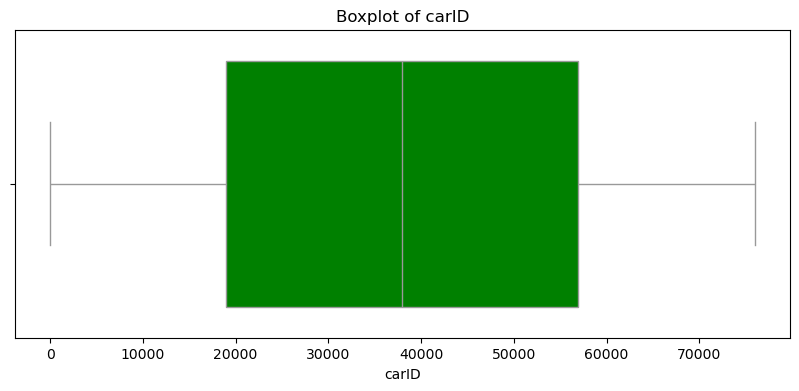

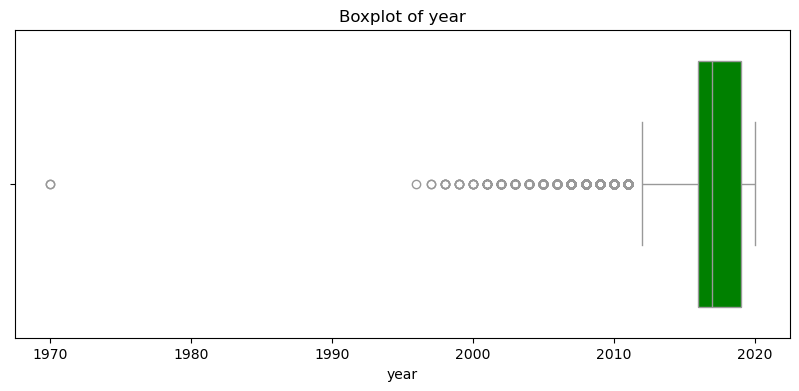

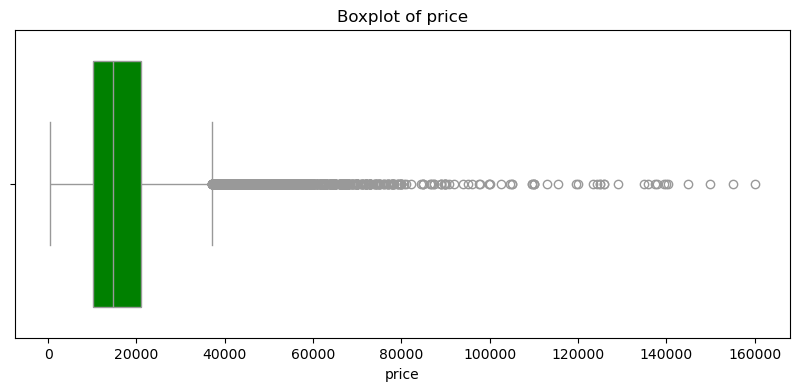

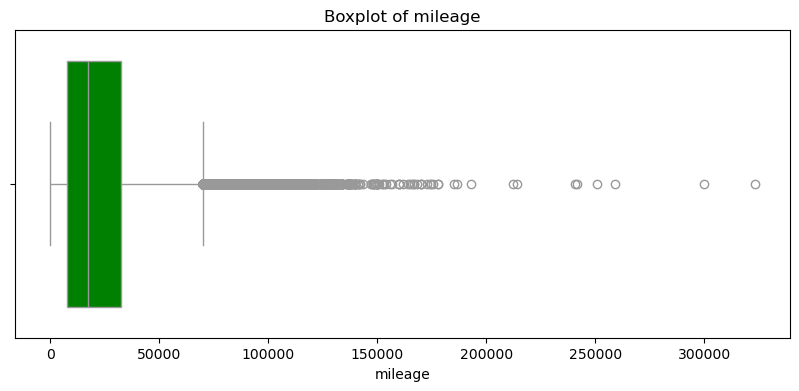

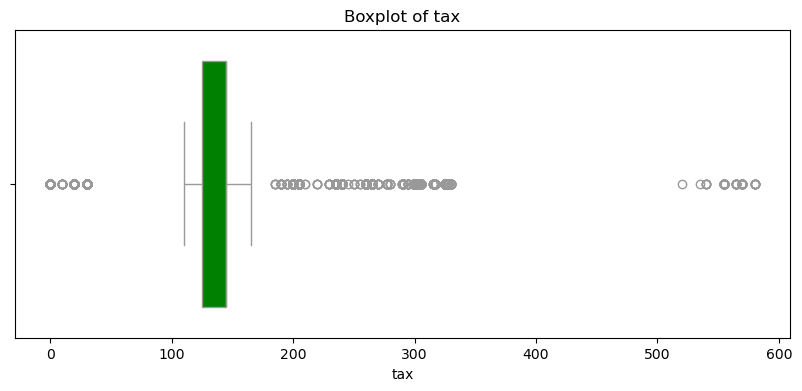

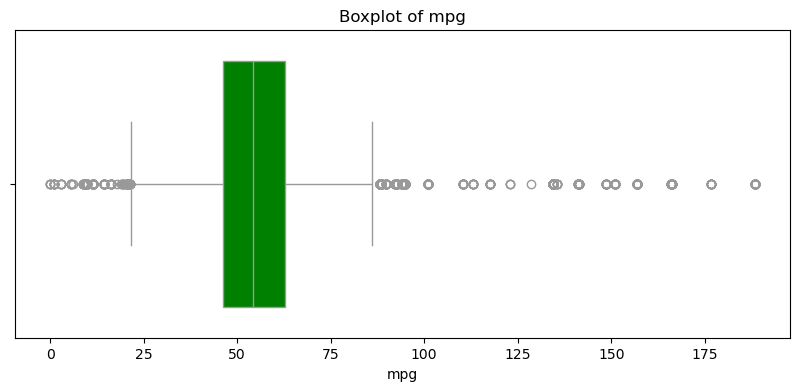

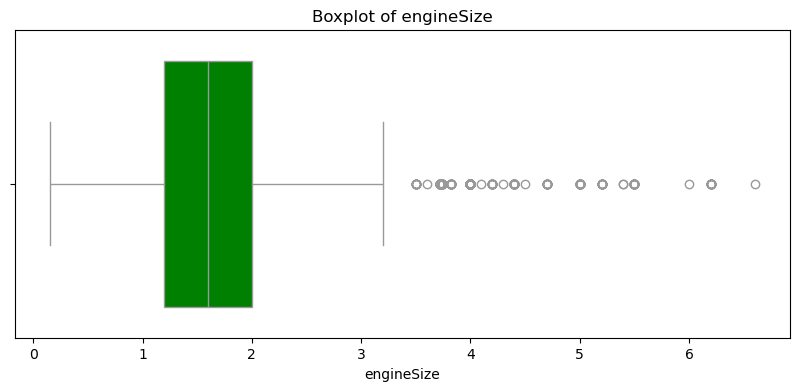

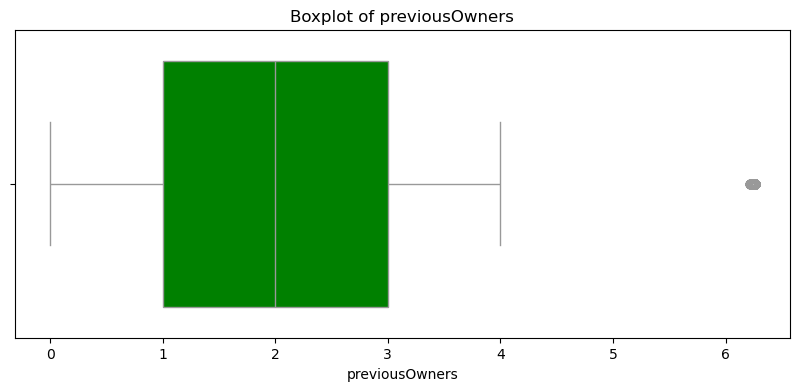

In [43]:
# Boxplots to check for outliers
for column in train.select_dtypes(include=['int64', 'float64']).columns:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=train[column], color='white', boxprops=dict(facecolor='green'))
    plt.title(f'Boxplot of {column}')
    plt.show()

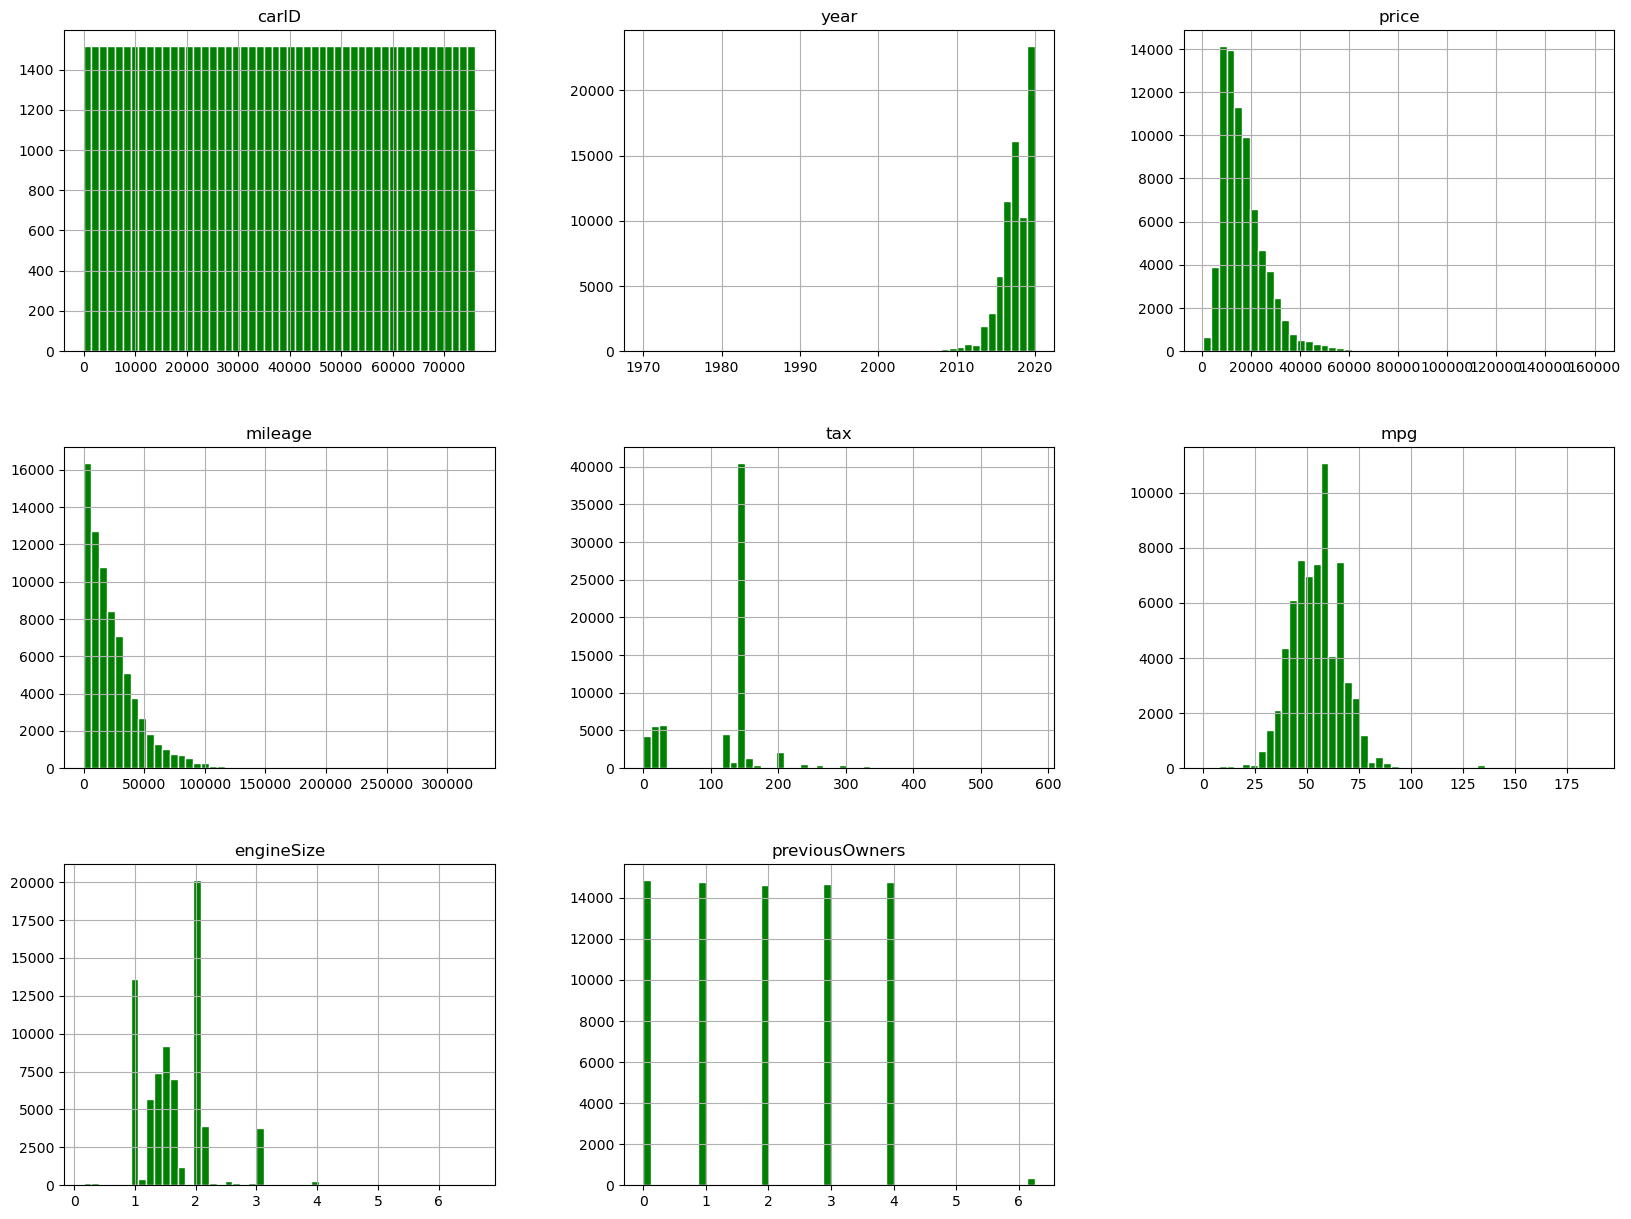

In [ ]:
# Histograms for each numerical attribute
train.hist(bins=50, figsize=(20,15), color='green', edgecolor='white')
plt.gcf().suptitle("Distribution of All Numerical Features in the Training Dataset",
                   y=1.02,
                   fontsize= 20)

We performed some distribution checks and log-scale exploration for key variables to consider preprocessing choices:

 - `mileage`: long right tail, being a proxy for usage.
 - `tax`: showcases discrete bands with a long tail.
 - `mpg`: moderately skewed.
 - `engineSize`: slightly skewed.
 - `price` : very skewed (long tail to the right)


If log1p visibly reduces skew or compresses heavy tails, we may apply the transformation later to improve linear-model assumptions (more stable variance, fewer outlier effects).

**Conclusions:**
* We can try using log in `Mileage` to help center the distributions, as it shows to reduce the right tail;
* In `price`, with a tail to the right, the log truly centers the distribution, being now approximate to a normal one. So there may be advantages in using `log(price)` as well;
* In `mpg` we see that this transformation is not necessary, as the original distribution is already somewhat centered and the log doesn't compress the extreme values in the right side of the distirbution (winsorization can help correct this);
* `engineSize` the distribution is already relatively well-behaved and strongly discretised into engine classes (has discrete bands, and not a huge tail just some extreme values);
* `tax` showcases descrete bands as well (which can represent groups of cars regrading tax paid) and a right skew. However, the log transformation did not improve significantly its distribution.

**Variables that can benefit from a log transformation: price and mileage.**
   


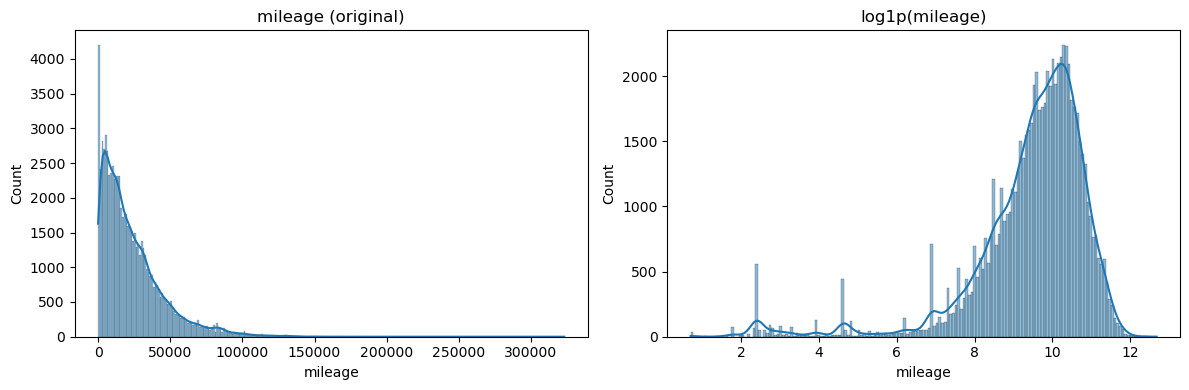

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(train["mileage"], kde=True, ax=axes[0])
axes[0].set_title("Mileage (Original)")

sns.histplot(np.log1p(train["mileage"]), kde=True, ax=axes[1])
axes[1].set_title("log1p(Mileage)")

fig.suptitle("Effect of log1p on Mileage Distribution",
             y=1.05,
             fontsize=16)

plt.tight_layout()
plt.show()


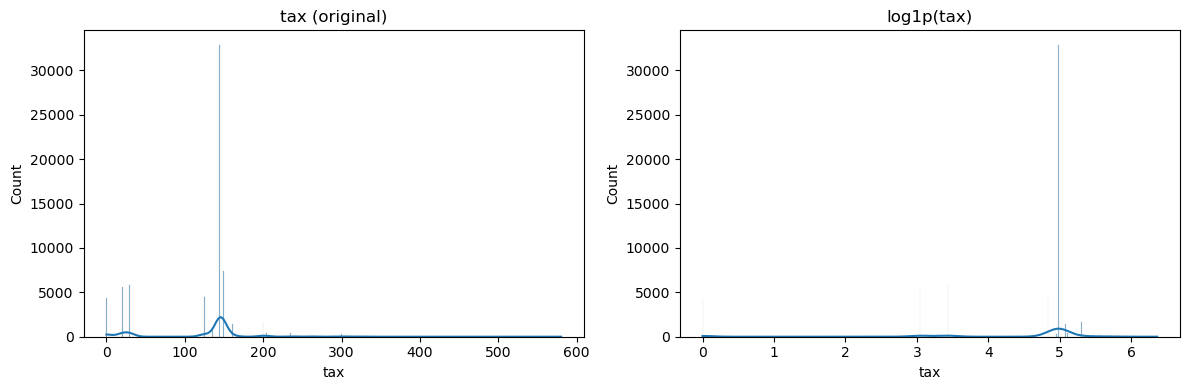

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(train["tax"], kde=True, ax=axes[0])
axes[0].set_title("Tax")

sns.histplot(np.log1p(train["tax"]), kde=True, ax=axes[1])
axes[1].set_title("log1p(Tax)")

fig.suptitle("Effect of log1p on Tax Distribution",
             y=1.05,
             fontsize=16)

plt.tight_layout()
plt.show()


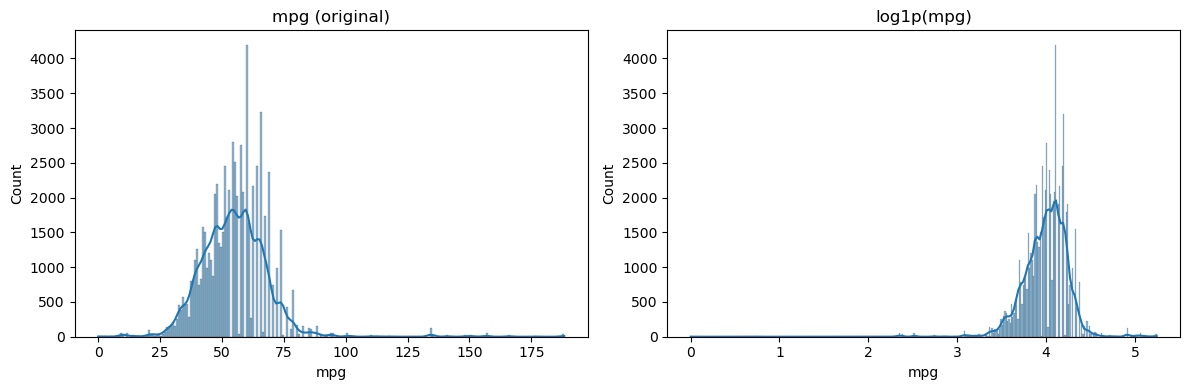

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(train["mpg"], kde=True, ax=axes[0])
axes[0].set_title("mpg")


sns.histplot(np.log1p(train["mpg"]), kde=True, ax=axes[1])
axes[1].set_title("log1p(mpg)")


fig.suptitle("Effect of log1p on mpg Distribution",
             y=1.05,
             fontsize=16)

plt.tight_layout()
plt.show()


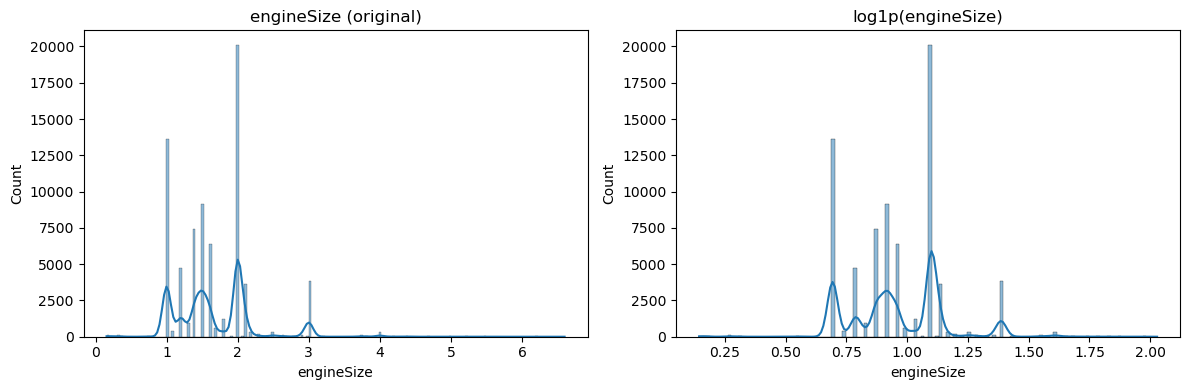

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))


sns.histplot(train["engineSize"], kde=True, ax=axes[0])
axes[0].set_title("engineSize")


sns.histplot(np.log1p(train["Engine Size"]), kde=True, ax=axes[1])
axes[1].set_title("log1p(Engine Size)")


fig.suptitle("Effect of log1p on Engine Size Distribution",
             y=1.05,
             fontsize=16)

plt.tight_layout()
plt.show()

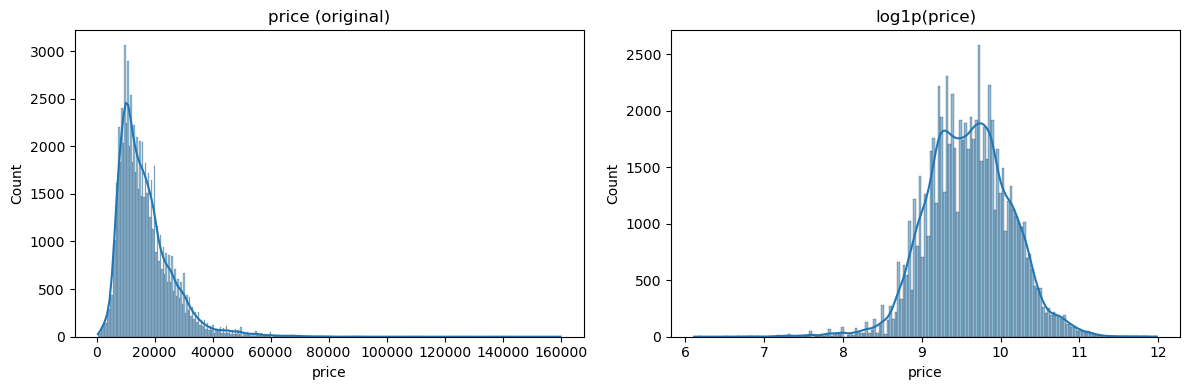

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.histplot(train["price"], kde=True, ax=axes[0])
axes[0].set_title("Price")

sns.histplot(np.log1p(train["price"]), kde=True, ax=axes[1])
axes[1].set_title("log1p(Price)")

fig.suptitle("Effect of log1p on Car Price Distribution",
             y=1.05,
             fontsize=16)

plt.tight_layout()
plt.show()

### 2.2.2 Multidimensional exploration 

In [50]:
brand_stats = (
    train
    .groupby('Brand')
    .agg(
        count=('price', 'size'),
        mean_price=('price', 'mean')
    )
    .sort_values('count', ascending=False)
)

transmission_stats = (
    train
    .groupby('transmission')
    .agg(
        count=('price', 'size'),
        mean_price=('price', 'mean')
    )
    .sort_values('count', ascending=False)
)

fuel_stats = (
    train
    .groupby('fuelType')
    .agg(
        count=('price', 'size'),
        mean_price=('price', 'mean')
    )
    .sort_values('count', ascending=False)
)


We can see big differences in prices for different brands, suggesting that brand is an important predictor of price, as we could expect. However, there's not a clear and observable relationship between the frequency of each brand and its price. Either way, there's some notes worth taking:

 1.   we clearly have **2 clusters of prices** here: high hand, with higher prices (mercedes, bmw and audi) and medium to cost friendly cars (ford, opel, toyota, skoda, hyundai and volkswagen);

 Considering this, a new **binary variable distinguishing these 2 price groups**, could help predict prices (something to be implemented in the feature engineering stages).

2.  toyota, skoda and hyundai are **the least frequent** and display on average **lower prices**;
3.  mercedes showcases the highest average price and it is the second most common car.
4. bmw and audi have similar frequencies and similar prices.

2, 3 and 4 suggest that **frequency encoding** might be a nice solution for brand, having a considerably high number of categories (one hot encoding would generate too many new features), however, there's no linear relationship. An alternative solution for the encoding of Brand can be One Hot Encoding, as we consider 9 new variables (dummies created) don't explode the number of features for our models.

Conclusion: we will test both frequnecy and one hot encodings on brand and see which one leads to the best results.

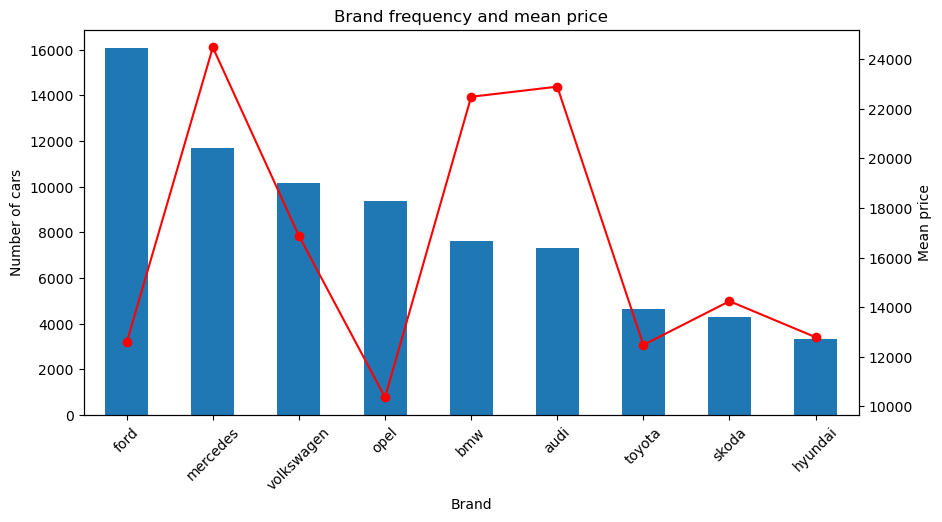

In [51]:
ax = brand_stats['count'].plot(kind='bar', figsize=(10, 5))
ax.set_ylabel("Number of cars")

ax2 = ax.twinx()
ax2.plot(brand_stats.index, brand_stats['mean_price'], marker='o', color='red')
ax2.set_ylabel("Mean price")

ax.set_title("Brand frequency and mean price")
ax.tick_params(axis='x', rotation=45)

We see considerable differences in price for the multiple transmission types, which means transmission might be a good predictor of price. More specifically we observe a big difference between manual cars an the other categories.

*  manual cars are the most common but the cheapest ones;
* semi-automatic and automatic cars are equally famous, but semi-automatic cars are significantly more expensive.
* other, only includes 5 cars, is clearly representing a rare segment of cars (can be considered noise even).

There's no clear relationship between price and frequency for the different types of transmission and few categories, therefore a nice option for encoding transmission is **One Hot Encoding**.

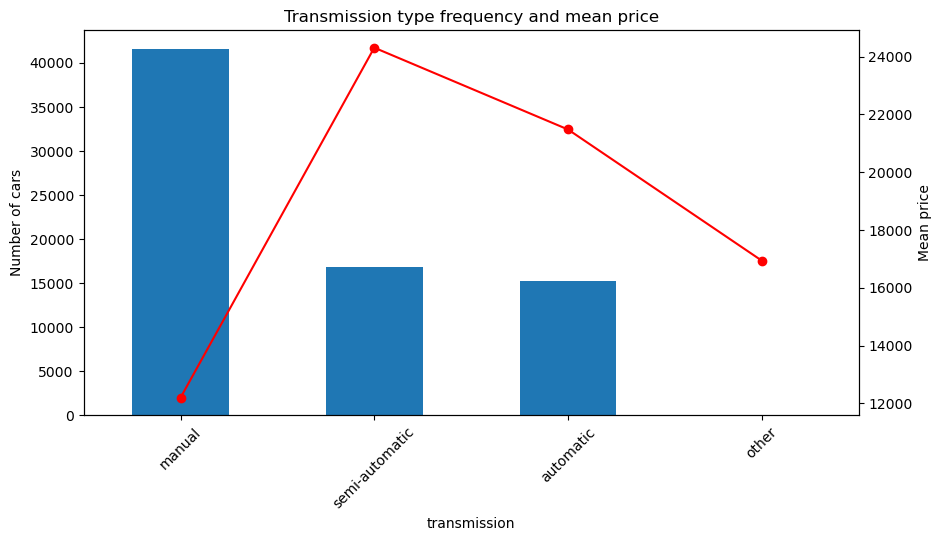

In [52]:
ax = transmission_stats['count'].plot(kind='bar', figsize=(10, 5))
ax.set_ylabel("Number of cars")

ax2 = ax.twinx()
ax2.plot(transmission_stats.index, transmission_stats['mean_price'], marker='o', color='red')
ax2.set_ylabel("Mean price")

ax.set_title("Transmission type frequency and mean price")
ax.tick_params(axis='x', rotation=45)

There's again differing average prices for each fuel type, therefore fuel is an important variable to consider.
*  petrol is the most common category but represents the cheapest cars;
* diesel and hybrid are the fuel types of the most expensive cars;
* there's only 4 eletric cares in our data;

This variable has low cardinality (few categories) therefore we may opt for **One Hot encoding** once again, as there's no clear relationship between price and frequency of fuel type categories.

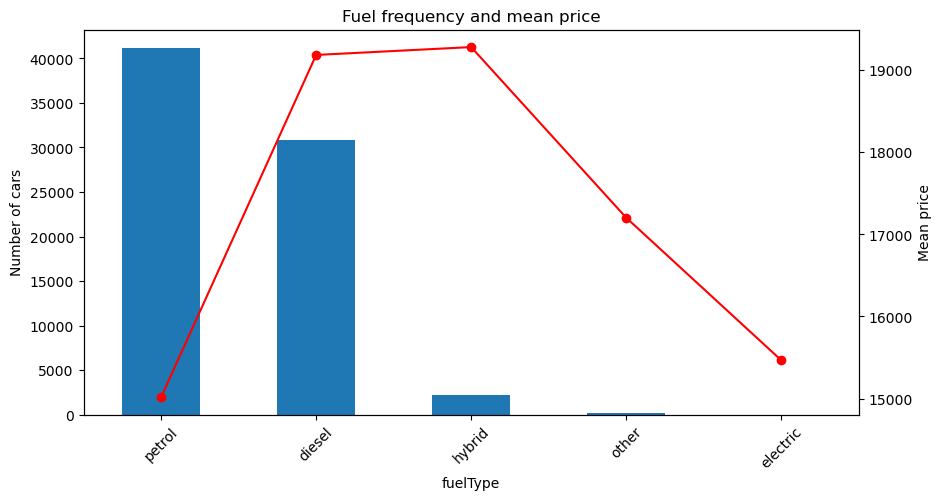

In [53]:
ax = fuel_stats['count'].plot(kind='bar', figsize=(10, 5))
ax.set_ylabel("Number of cars")

ax2 = ax.twinx()
ax2.plot(fuel_stats.index, fuel_stats['mean_price'], marker='o', color='red')
ax2.set_ylabel("Mean price")

ax.set_title("Fuel frequency and mean price")
ax.tick_params(axis='x', rotation=45)

Using JointGrids with the scatter of price vs independent feature and marginal histograms with the purpose of checking monotonic trends, linearity, and outliers. In a perfect scenario, we are looking to identify clear upward/downward trends, that would suggests positive/negative association with price.

The first visualization of price vs tax:
* Showcases a central group, of more regular values of tax and an additional group (smaller, thus more unusual) in the right hand side with higher values of tax but that doesn't display a specific relationship with price, only stretch the tail of the distribution of `tax`. We will **winsorize this variable, on the 99,2% quantile**, to preserve the normal tax behavior but still correct the more extreme cases.

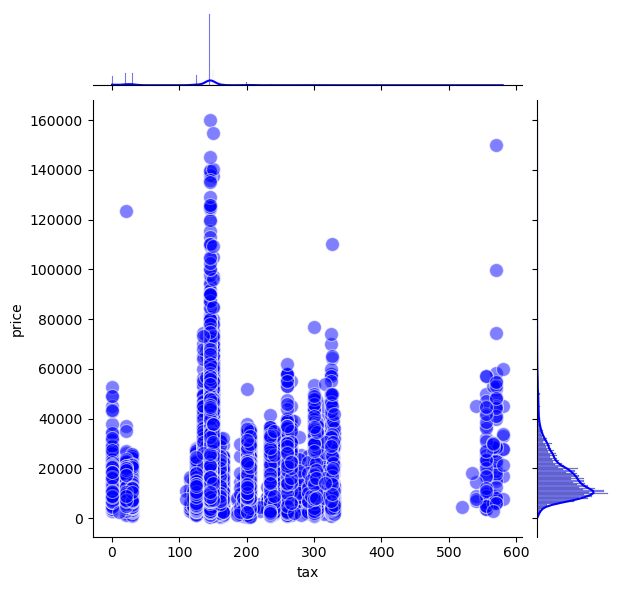

In [ ]:
# Bivariate exploration: price ~ tax
exp_prictax = sns.JointGrid(data=train, x="tax", y="price")
exp_prictax.plot_joint(sns.scatterplot, s=100, alpha=.5, color='blue')
exp_prictax.plot_marginals(sns.histplot, kde=True, color='blue')

exp_prictax.fig.suptitle("Bivariate Exploration: Price vs. Annual Tax",
                        y=1.02,
                        fontsize=16)
plt.show()

The relationship between these variables is easy to understand, even though is not linear: cars with more kilometers (higher mileage) are cheaper; but for extreme values of mileage the prices don't drop anymore. Therefore, the few cars with a huge amount of kilometers don't add any new information/structure, only stretch the tail further to the right, which can worsen the performance of the models.

For this reason, we will **winsorize mileage** (in the 99,2% quantile), to preserve the natural tendency of the variable but limiting the influence of extreme cases.

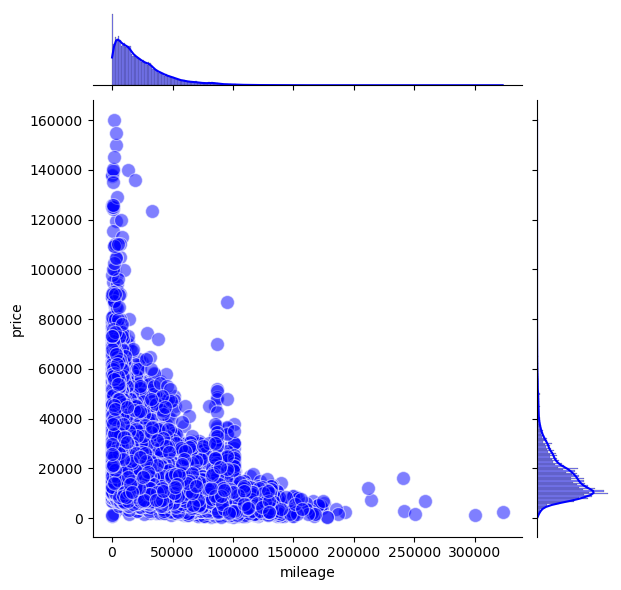

In [ ]:
# Bivariate exploration: price ~ mileage
exp_pricmil = sns.JointGrid(data=train, x="mileage", y="price")
exp_pricmil.plot_joint(sns.scatterplot, s=100, alpha=.5, color='blue')
exp_pricmil.plot_marginals(sns.histplot, kde=True, color='blue')

exp_pricmil.fig.suptitle("Bivariate Exploration: Price vs. Mileage",
                        y=1.02,
                        fontsize=16)

plt.show()

We observe the majority of points being concentrated between 0 and 110 approximatly. In the right hand side there's a sparcer group of cars, exhibiting higher values of `mpg` that don't showcase any specific relationship with price. Possibly, these can be measuring errors or very specific car models that are not representative of the usual behavior of `mpg`.  To diminish the weight of these data points in the models, we will winsorize `mpg` (<1% of the tail).


Note that `mpg` can be interpreted as *"How far can I get on a tank?"*: very high values of miles per gallon translate into economic cars, that don't consume a lot. On the other hand, low `mpg` translates into low number of kilometers per gallon (cars that consume a lot), which are the cars showcasing the higher prices.

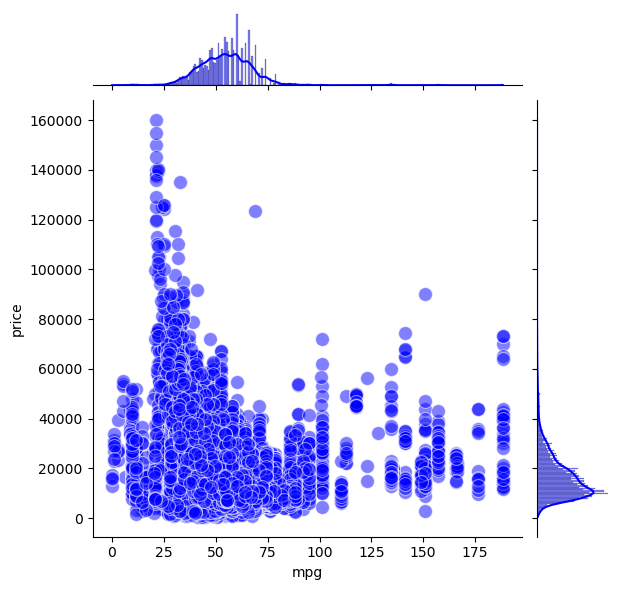

In [ ]:
# Bivariate exploration: price ~ mpg
exp_pricmpg = sns.JointGrid(data=train, x="mpg", y="price")
exp_pricmpg.plot_joint(sns.scatterplot, s=100, alpha=.5, color='blue')
exp_pricmpg.plot_marginals(sns.histplot, kde=True, color='blue')

exp_pricmpg.fig.suptitle("Bivariate Exploration: Price vs. mpg",
                        y=1.02,
                        fontsize=16)

plt.show()

We identify some outliers in the right hand side of the graph, of cars with big engine sizes (>4 L). These cars with a big engine, showcase very high prices therefore representing a segment of cars worth keeping. However, there's some cars passing the 6L mark that have low prices. Therefore we can say that cars with engine sizes higher than 6L are somewhat noisy and could be winsorized.

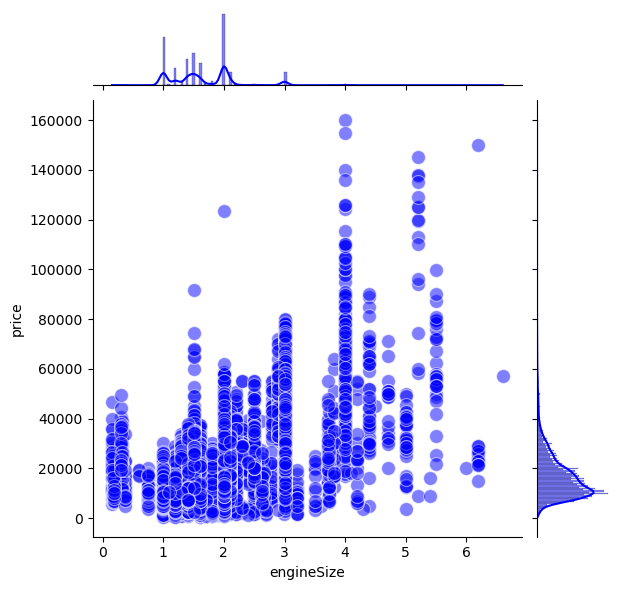

In [ ]:
# Bivariate exploration: price ~ engineSize
exp_pricengs = sns.JointGrid(data=train, x="engineSize", y="price")
exp_pricengs.plot_joint(sns.scatterplot, s=100, alpha=.5, color='blue')
exp_pricengs.plot_marginals(sns.histplot, kde=True, color='blue')

exp_pricengs.fig.suptitle("Bivariate Exploration: Price vs. Engine Size",
                        y=1.02,
                        fontsize=16)

plt.show()

`Year` has the majority of its values comprised between 1995 and 2020, however there's some cars from 1970 (approximately) wich could be considered statistical outliers. However these might represent a special segment worth keeping.

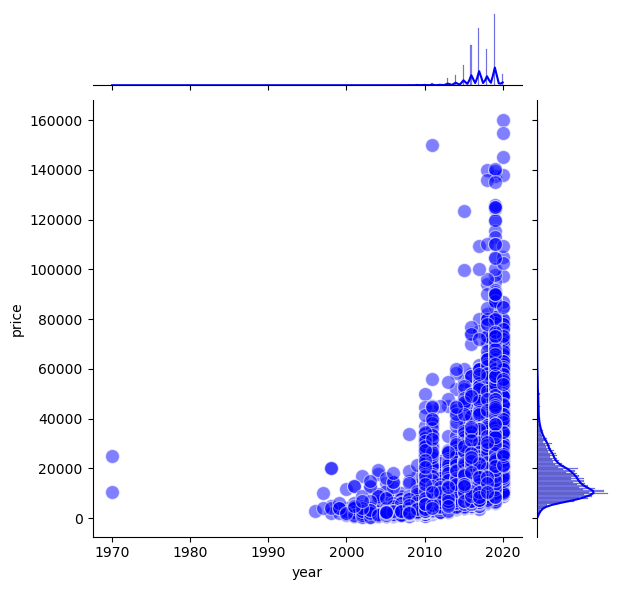

In [ ]:
# Bivariate exploration: price ~ year
exp_pricye = sns.JointGrid(data=train, x="year", y="price")
exp_pricye.plot_joint(sns.scatterplot, s=100, alpha=.5, color='blue')
exp_pricye.plot_marginals(sns.histplot, kde=True,color='blue')

exp_pricye.fig.suptitle("Bivariate Exploration: Price vs. Year",
                        y=1.02,
                        fontsize=16)


plt.show()

The pairplot bellow represents the relationships between all numeric variables:
* we can see there's no clear linera relationship between features;
* and, as previously observed, there's also no linear relationships between features and the target (price)

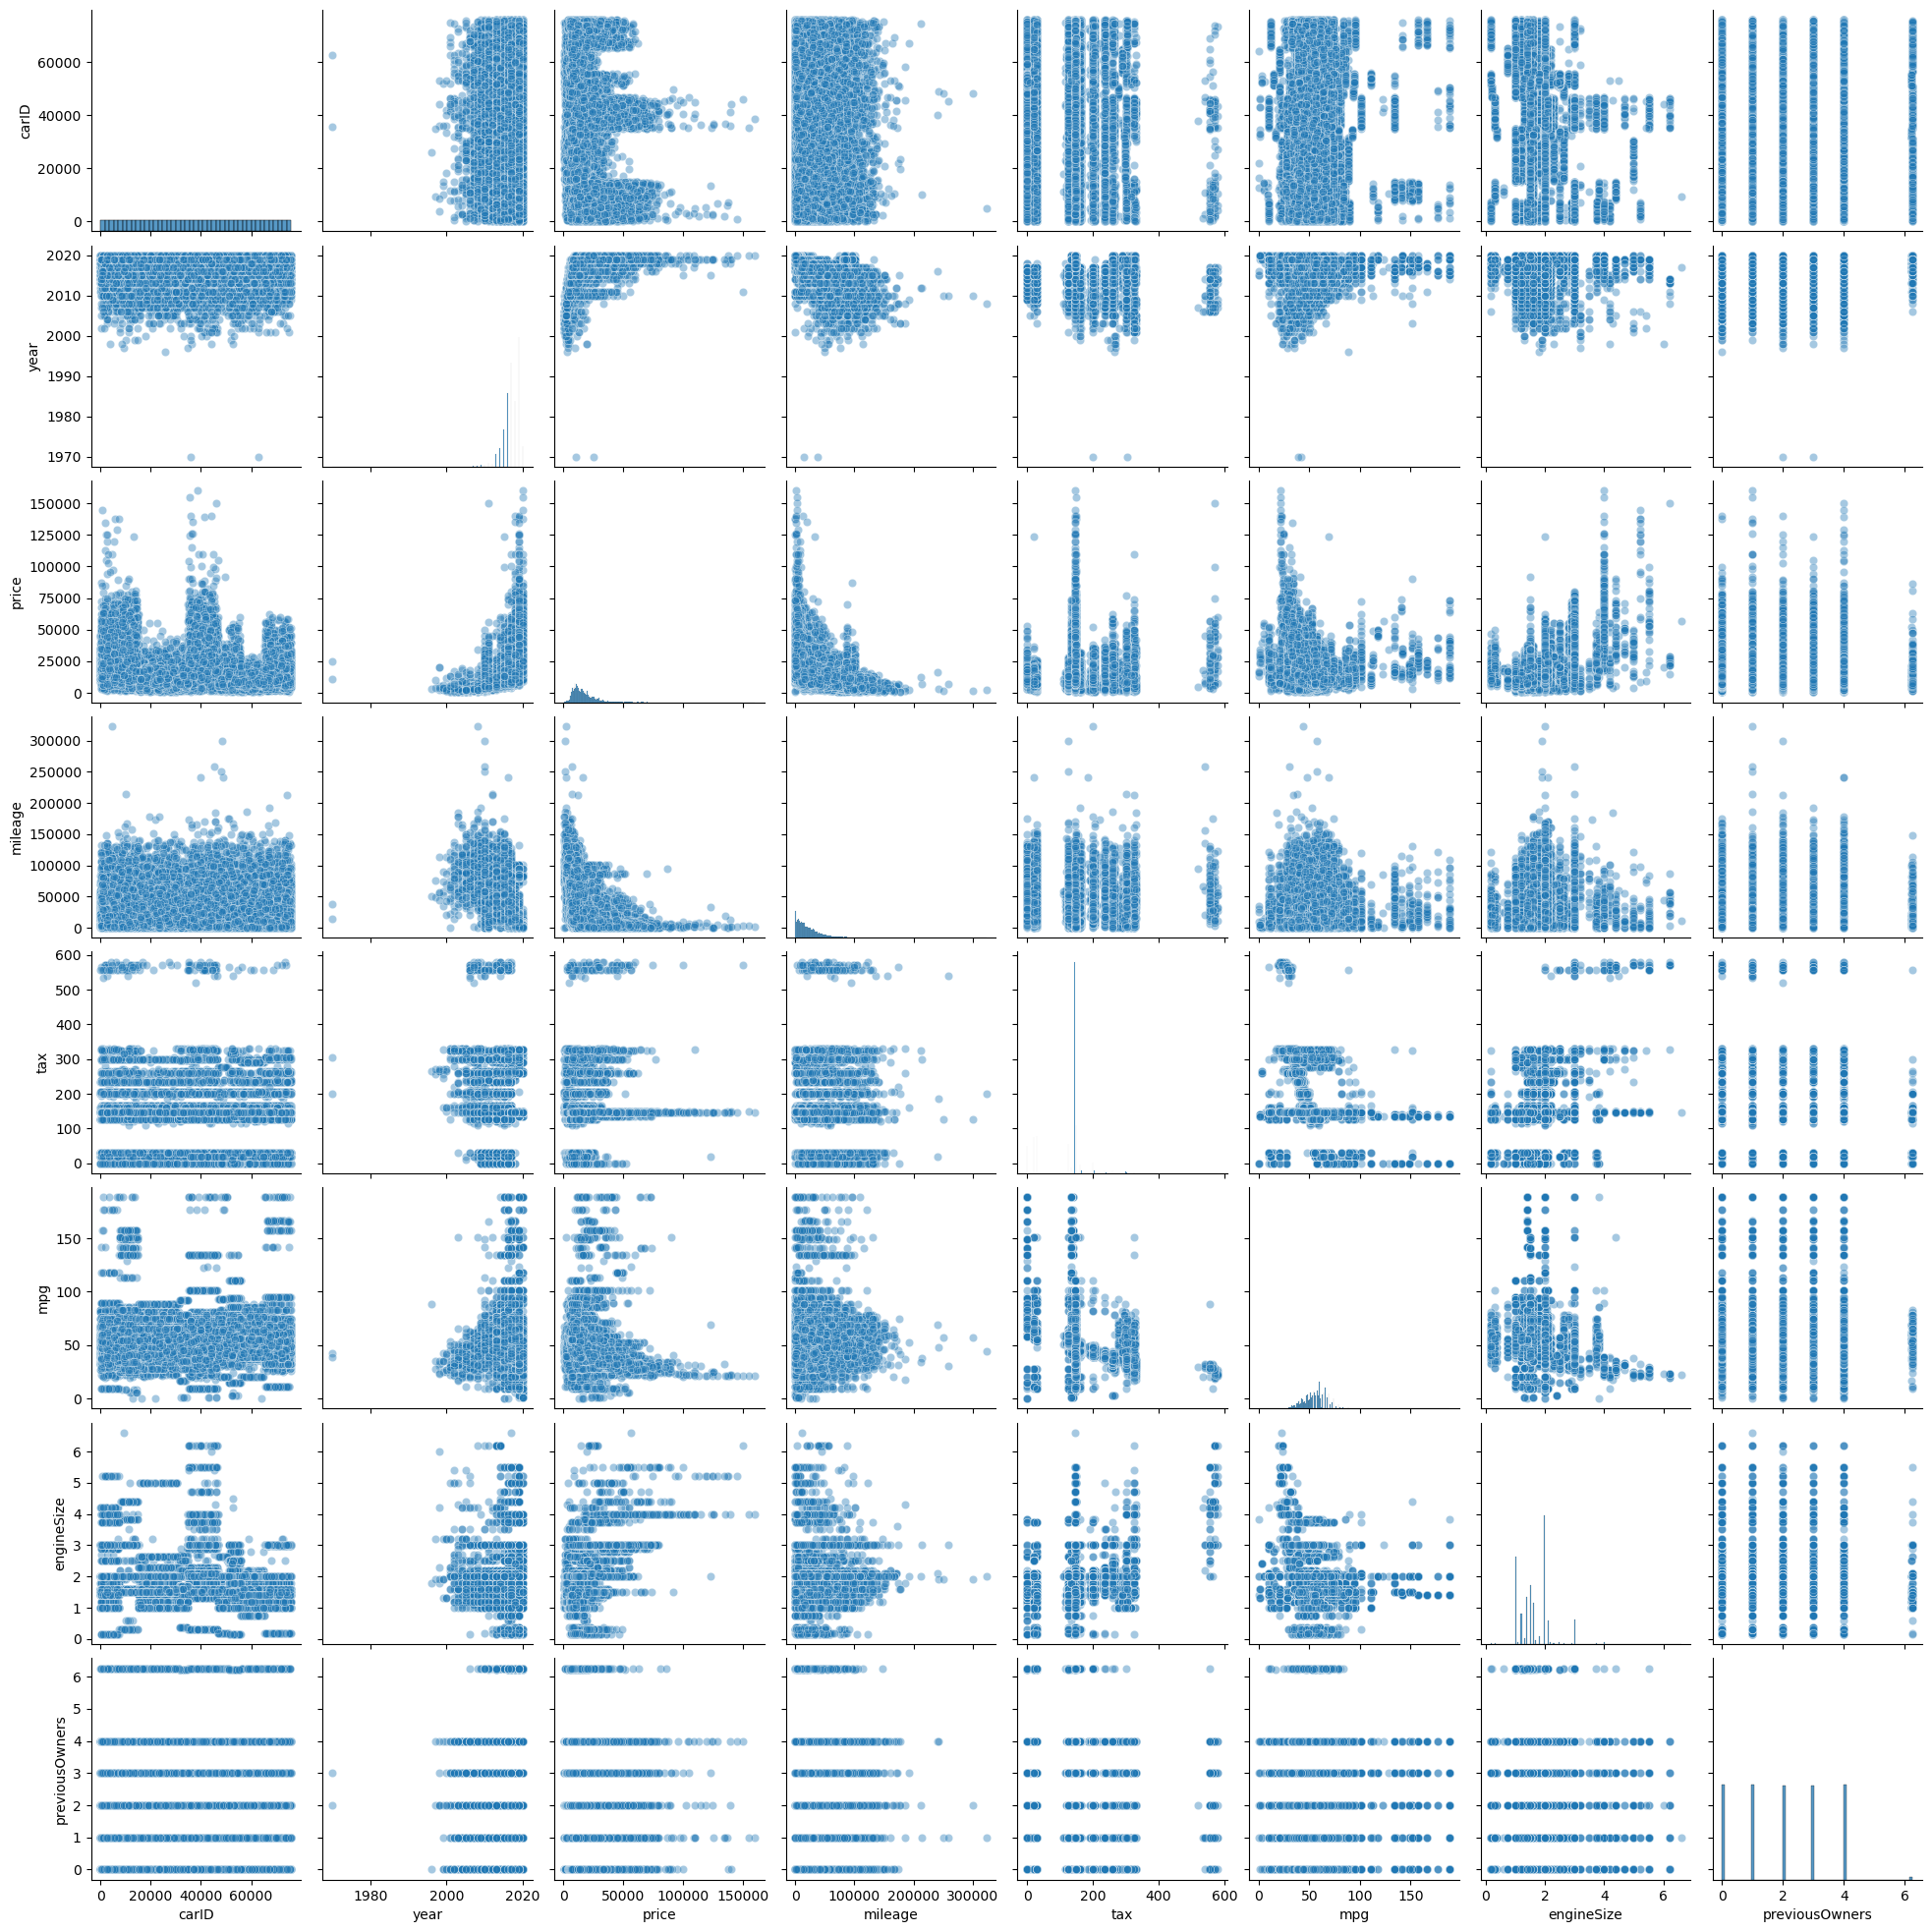

In [ ]:
sns.pairplot(train,plot_kws={'alpha':0.4})

g.fig.suptitle("Scatter Plot Matrix of Training Data Features",
               y=1.02,
               fontsize=20)

plt.show()

The correlation matrix quanifies the relationships above represented in the scatter plots.

* The highest correlations exhibited involve **price, mileage and year**, meaning that year and mileage will be good predictors of price. 
* On the other hand, **paint quality and previous onwers** display 0 correlation with the target, probably having very **low predictive power**.

It is important to note that this visualization it is only suggestive, and we must not take any action based on it, since it uses both train and validation data to compute the correlations. Feature selection  will be performed inside in the k-fold implementation.

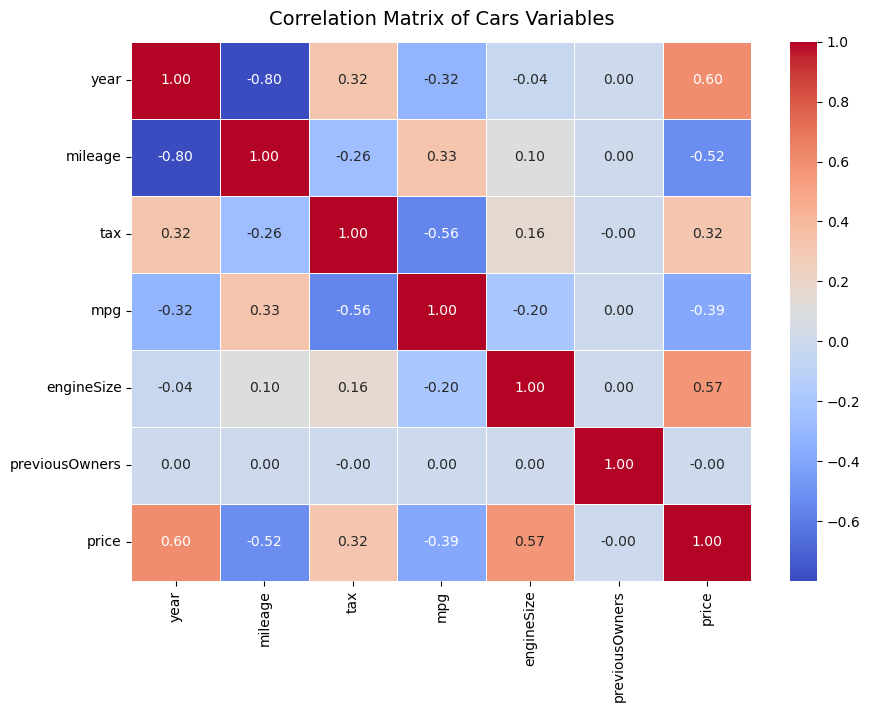

In [60]:
num_cols=['year', 'mileage', 'tax', 'mpg', 'engineSize', 'previousOwners', 'price']

# Calculate correlation matrix
corr_matrix = train[num_cols].corr(method='spearman')

# Create the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5
)

plt.title("Correlation Matrix of Cars Variables", fontsize=14, pad=12)
plt.show()

Finally, to better understand the main characteristics of cars for many price points, we split the target (price) into 10 deciles (0 = 10% cheapest … 9 = 10% most expensive), an observe the median value of year, mileage, engineSize, mpg and tax, for each of the deciles. This "profiling" of price deciles helps understand how features vary according to price.

For interpretation purposes we normalized the variables using min–max so that all of them have a 0–1 scale. This scaler is sensitive to outliers, however, this is just used for interpretation and conclusions will be taken with a grain of salt.


 All these variables vary between price deciles, meaning they potentially have insights useful for prediction.
 - `mileage` decreases in higher deciles (more expensive cars tend to have fewer miles.)
 - `year` increases in higher deciles ( more expensive cars are more recent.)
 - `engineSize` increases in top deciles (larger engines in premium segments.)
 - `mpg` decreases as price increases (efficiency vs. performance trade-off.)
 - `tax` tends to increase with price (discrete bands linked to emissions/engine size).

Text(0.5, 1.0, 'Price decile profiles')

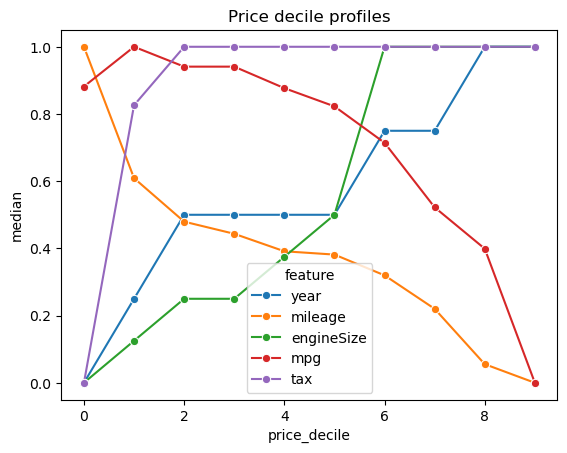

In [61]:
# Price decile profiles
train_viz = train.copy()
train_viz["price_decile"] = pd.qcut(train_viz["price"], 10, labels=False)
agg = train_viz.groupby("price_decile").agg({
    "year":"median", "mileage":"median", "engineSize":"median", "mpg":"median", "tax":"median",
}).reset_index().melt("price_decile", var_name="feature", value_name="median")


# 0–1 normalization by feature
agg["median"] = agg.groupby("feature")["median"].transform(
    lambda s: (s - s.min()) / (s.max() - s.min()) # min max scaler
)

sns.lineplot(data=agg, x="price_decile", y="median", hue="feature", marker="o")
plt.title("Price decile profiles")


<a id="3"></a>

# **3. Feature Engineering**

We decided on creating 4 new variables:
* `car_age`: how old the car is based on year column.

* `mileage_per_year`: a proxy for how used the car is, combining year (how old) and mileage (how worked out is)

* `is_high_end`: a flag to distinguish higher hand brands. (boolean)

* `engine_per_litre_efficiency`: efficiency per motor capacity, a ratio between miles per gallon and engine size.

Additionally, as the previous viusalizations revealed that log transformations helped center de the distributions of some variables, we are going to apply them later, to `price` and `mileage`, inside the cross validation pipeline.

In [62]:
# some random examples of higher hand brands that might exist on the dataset
LUXURY = {"audi","bmw","mercedes","jaguar","porsche","lexus","volvo","land rover"}

def add_features(df):
    df = df.copy()
    # 1) car_age
    if "year" in df:
        df["car_age"] = 2020 - df["year"]

    # 2) mileage_per_year (careful with div/0 e NaN)
    if {"mileage","year"}.issubset(df.columns):
        age = (2020 - df["year"]).replace(0, np.nan)
        df["mileage_per_year"] = (df["mileage"] / age).replace([np.inf, -np.inf], np.nan)

    # 3) is_high_end (NaN -> 0)
    if "Brand" in df:
        df["is_high_end"] = df["Brand"].isin(LUXURY).astype(int).fillna(0)

    # 4) engine_per_litre_efficiency (protect denom=0)
    if {"mpg","engineSize"}.issubset(df.columns):
        denom = df["engineSize"].replace(0, np.nan)
        df["engine_per_litre_efficiency"] = (df["mpg"] / denom).replace([np.inf, -np.inf], np.nan)

    return df

In [63]:
train = add_features(train)
test = add_features(test)

It is important to attempt to assess the predicitve power of these engineered features, and the multicolinearity with the original ones. 

Analysing the correlations matrix:
* `car_age` and `year`, as expected are perfectly correlated and are equally correlated with the target. Therefore we should maintain just one (the new, car_age) and delete `year`.
* `engine_per_litre_efficiency`, `car_age`, `mileage_per_year` all showcase correlations above 0.5 (or bellow -0.5) therefore all seem to be meaningful to predict price.

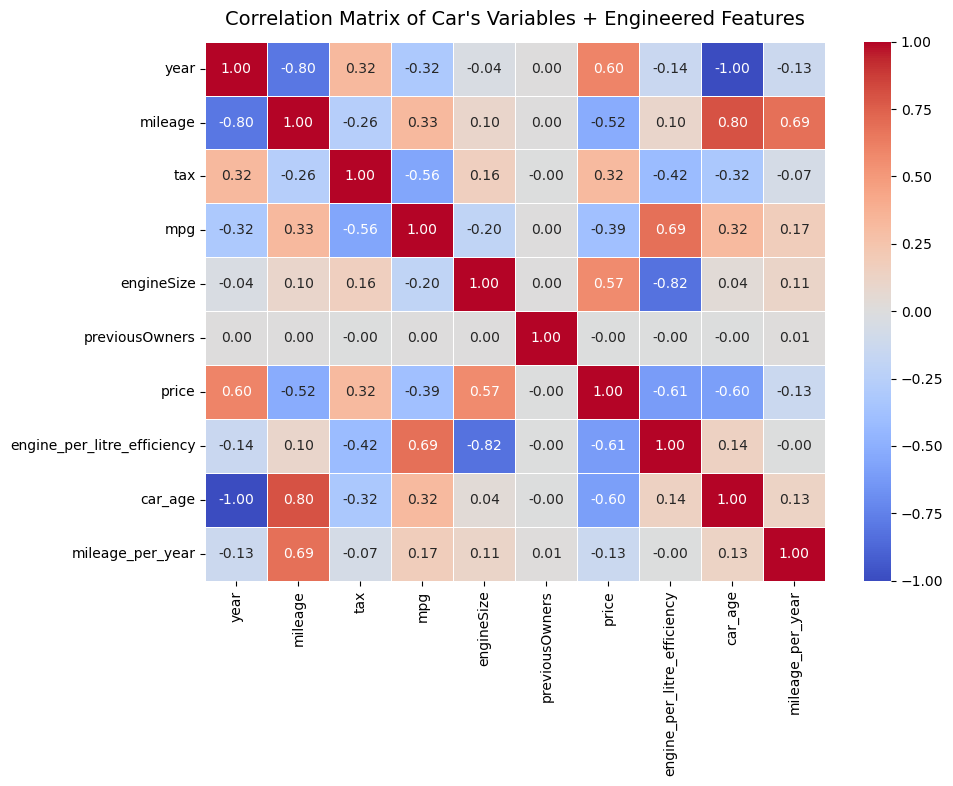

In [64]:
num_cols=['year', 'mileage', 'tax', 'mpg', 'engineSize', 'previousOwners', 'price',
          'engine_per_litre_efficiency', 'car_age', 'mileage_per_year']

# Calculate correlation matrix
corr_matrix = train[num_cols].corr(method='spearman')

# Create the heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5
)

plt.title("Correlation Matrix of Car's Variables + Engineered Features", fontsize=14, pad=12)
plt.show()

In [65]:
train = train.drop(columns=['year'])
test = test.drop(columns=['year'])

### II.2. Cleaning and preprocessing strategy

At this point, we are well informed to come up with a strategy, and to summarize the steps already applied.
Based on the EDA, we designed a preprocessing pipeline with the following main components:

- **1.Text normalisation for `Brand` and `model`**  (already applied in the steps above)

  We applied a custom `norm_text` + `clean_model` procedure to enforce consistent spelling and formatting of brand, model, transmission and fuelTypes. For the first, we deliberately avoided fuzzy matching to prevent accidental merges between genuinely different models. For the other 3, functions were defined to apply fuzzy matchig. Extremely short or junk tokens (e.g. single letters) are mapped to `NaN`. It is relevant to note that our fuzzy matching implementation works in such a way that creates dictionaires of suggested corrections for each typo, and applies it on each car with categories differing from the canonical values. Therefore, applying it outside of the pipeline doesn't constitute data lekeage.


- **2.Feature engineering**  (already applied in the steps above)

  We engineered several variables that were more directly interpretable than the raw inputs, such as:
  - `car_age` (current year minus registration year),
  - `mileage_per_year` (total mileage divided by car_age, when available),
  - `engine_per_litre_efficiency` (mpg per litre of engine size).
  These features capture usage intensity and efficiency in a more stable way than raw mileage or mpg alone.

- **3.Outlier treatment via winsorization** (to apply inside CV)

  To limit the influence of extreme values without discarding observations, we applied clipping inside the CV pipeline to `mileage`, `tax` and `mpg` at a high quantile (e.g. 99.2%). The clipping thresholds (`clip_info`) are learned on the training fold only and then reused for validation and test, ensuring no leakage.


- **4.log transformations** (to apply inside CV)

  To help center the most skewed distributions, we apply log1 tranformations in `mileage` and `price`. In the case of price, before reporting any model performance metrics, or price predictions to export to kaggle, we revert the log1(price), so that the scale is aligned to the original form.


- **5.Encoding of categorical variables** (to apply inside CV)

  High-cardinality fields  (`model` and possibly `Brand`) are transformed via **frequency encoding**, replacing each level by its relative frequency in the training fold. Lower-cardinality variables such as `fuelType` and `transmission` are one-hot encoded after imputing missing values with the mode. The set of dummy columns created in the training fold is stored and reused to align validation and test matrices.


- **6.Missing-value imputation and scaling** (to apply inside CV)

  Numerical features are imputed with the median of the training fold and, for models that are sensitive to feature scales (e.g. linear models, KNN, MLP, gradient boosting), we apply a `RobustScaler`. The imputation vector and scaler are fitted **only on the training split** and then applied to the corresponding validation split and to the final test data. Categorical features will be imputed with the mode, except for `Brand` and `model` that will have a category unknown grouping the missing values, instead of imputing with some statistic.


- **7.Feature selection inside CV**  
  When feature selection is used (e.g. `SelectKBest` or RFE), the selector is fitted on the training fold and then applied to the validation fold through our `run_model` / `evaluate_model` functions. This guarantees that the choice of features is not influenced by the validation data.


Steps 3 to 7 are implemented inside our custom `run_model` (fit-time) and `transform_X` / `evaluate_model` (transform-time) functions, so that every aspect of preprocessing is learned within the cross-validation loop and reapplied consistently at deployment time.

<a id="3"></a>

# **4. Split using K-fold Cross Validation**

The present section applies all preprocesing steps that weren't applied yet (3. to 7., as the previous summary outlines) and makes predictions to obtain price (predicted values), and compare them to the real values.

 We will start by runing a plenthora of models, including algorithms discussed in the course (linear regressions, KNN, DT, Random Forest, GBR and MLP) and other models that seemed suitable for the problem (other ensembles that usually perform well in these problems).

**Model Assessment strategy:**
 We evaluated models through 3-fold cross validation, reporting MAE, RMSE, adjusted R2 and R2.

 We will be focusing primarily on **Mean Absolute Error**,  since it is directly interpretable as average absolute pricing error in £ per car and is robust to occasional extreme prices (does not penalize larger errors). As secondary strategy, we analyse R2, to understand how much the variability of price is explain by our model, and adjusted R2 when testing solutions using differing number of features.

 The we have 4 functions that work together and apply the cross validation pipeline:
 * `run_model`: fits all the preprocessing and the model on the training data and returns all the necessary elements to transform train, validation and test data;

 * `transform_X`, used inside `evaluate_model` and `predict_on test`; applies (transform) all preprocessing steps fitted in `run_model` to validation and test.

 * `evaluate_model` makes predictions and compares them to the real values; it is used both on trainning and validation data.

 * `avg_scores` makes the for loop splitting the data into 3 folds and coordinates `run_model` and `evaluate_model`, to fit on each fold the train and predict on train and test.

 * `predict_on test` preprocesses the test data, using `transform_X` and makes predictions.

Separating the taget from the independent features, and dropping the `carID` to prevent it from being used in the model.

In [66]:
TARGET = 'price'
X_train_val = train.drop(columns=[TARGET, 'carID'])
y_train_val = train[TARGET]

<a id="3"></a>

# **5. Model Benchmarking**

## 5.1. Common baseline pipeline

For the initial testing of models, we decided on a common baseline pipeline, using the same preprocessing for all models to compare their results accuratly.
* **One Hot encoding** for `transmission`, `fuelType` and `Brand`, and **frequency encoding** for `model`.
* **Categorical Imputation**: impute with the mode in `trasmission` and `fuelType`; `Brand` and `model` will not be imputed, to not incur into creating unreal combinations of brand-model. For brand, there will be a category called unknown, and for model all Nans will have 0.0 frequency.
* **Numeric imputation**: all numeric variables will be imputed with the median.
* **Scaler**: use the Robust Scaler for all models
* **Selector**: selectkbest (filter method) with k=23 (before feature selection we have 29 variables), for all models.
* **Winsorization**: in the columns `mileage`, `tax` and `mpg`, in the quantile 99,2.
* **log transformations**: used on price and mileage;

## 5.2. Benchmark (at least 5 models from class)

Models to test:
* **Linear Regressions**: ridge and huber
* **KNN** with 10 neighboors (ball tree to improve the efficiency and runing time), and weights associated to distance.
* **Decision tree**: with prepruning (a simple DT almost always overfits)
* Bagging ensembles: **Random forest**, with also some pruning applied, **Bagging Regressor**, that uses all features (no bootstrap of features, only samples) and **Extra Tress Regressor** (extremely randomized trees) with no bootstrap that uses randomized splits.
* Boosting ensembles: **Gradient Boost Regressor** and **Hist gradient boost regressor**: with a defined max depht (4), and learning rate of 0.05.
* **MLP** with 2 hidden layers (15 neurons in the first one and 10 on the second), 500 iterations, learning rate of 0.01 and solver adam.

In [67]:
# instance of KFold with 3 folds
kf = KFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
models_to_try = [
    (
        "Ridge_alpha0.5",
        Ridge(alpha=0.5),
        RobustScaler(),
        SelectKBest(score_func=lambda X, y: mutual_info_regression(X, y, random_state=42), k=23)
    ),
    (
        "Huber_eps1.35_alpha1e-4",
        HuberRegressor(
            epsilon=1.35,
            alpha=0.0001,
            max_iter=1000
        ),
        RobustScaler(),
        SelectKBest(score_func=lambda X, y: mutual_info_regression(X, y, random_state=42), k=23)
    ),
    (
        "KNN_k10_distance",
        KNeighborsRegressor(
            n_neighbors=10,
            algorithm= 'ball_tree',
            weights='distance',
            p=2              # Euclidian Distance
        ),
        RobustScaler(),
        SelectKBest(score_func=lambda X, y: mutual_info_regression(X, y, random_state=42), k=23)
    ),
    (
        "DecisionTree_reg",
        DecisionTreeRegressor(
            max_depth=15,        # intial preprunning strategy, as simple DTs almost always overfit
            min_samples_split=40,
            min_samples_leaf=20,
            random_state=42
        ),
        RobustScaler(),
        SelectKBest(score_func=lambda X, y: mutual_info_regression(X, y, random_state=42), k=23)
    ),
    (
        "RandomForest",
        RandomForestRegressor(
            n_estimators=300,
            max_depth=15,       
            min_samples_split = 40,
            min_samples_leaf = 20,
            random_state=42,
            n_jobs=-1
        ),
        RobustScaler(),
        SelectKBest(score_func=lambda X, y: mutual_info_regression(X, y, random_state=42), k=23)
    ),
    (
        "BaggingRegressor",
        BaggingRegressor(
            estimator=DecisionTreeRegressor(
            max_depth=15,
            min_samples_split = 40,
            min_samples_leaf = 20,
            ),
            max_samples=0.7,
            bootstrap=True,
            random_state=42,
            n_jobs=-1
        ),
        RobustScaler(),
        SelectKBest(score_func=lambda X, y: mutual_info_regression(X, y, random_state=42), k=23)
    ),
    (
        "ExtraTreesRegressor",
        ExtraTreesRegressor(
            n_estimators=300,
            max_depth=15,
            min_samples_split = 40,
            min_samples_leaf = 20,
            random_state=42,
            n_jobs=-1),
        RobustScaler(),
        SelectKBest(score_func=lambda X, y: mutual_info_regression(X, y, random_state=42), k=23)
    ),
    (
        "GBR",
        GradientBoostingRegressor(
            random_state=42,
            learning_rate=0.05,
            max_depth=8,
        ),
        RobustScaler(),
        SelectKBest(score_func=lambda X, y: mutual_info_regression(X, y, random_state=42), k=23)
    ),
    (
        "HistGBR",
        HistGradientBoostingRegressor(
            random_state=42,
            learning_rate=0.05,
            max_iter=300,
            max_depth=8,
        ),
        RobustScaler(),
        SelectKBest(score_func=lambda X, y: mutual_info_regression(X, y, random_state=42), k=23)
    ),
    (
        "MLP",
        MLPRegressor(
          max_iter=500,
          verbose=False,
          solver='adam',
          activation='relu',
          learning_rate_init=0.01,
          batch_size=256,
          hidden_layer_sizes=(15, 10),
          random_state=42),
        RobustScaler(),
        SelectKBest(score_func=lambda X, y: mutual_info_regression(X, y, random_state=42), k=23)
    ),
]

results = []

for name, model, scaler, selector in models_to_try:
    print(f"\n\n===== {name} =====")

    summary, _ = avg_scores(
        kf, X_train_val, y_train_val,
        model=model,
        scaler=scaler,
        fill_method='median',
        selector=selector,
        fe_freq_cols=('model',),
        ohe_cols=('fuelType','transmission', 'Brand'), use_log_target=True,
        clip_cols=('mileage','tax', 'mpg'),
        clip_quantile=0.992
    )

    mae_train = summary.loc["MAE", "Train"]
    mae_val = summary.loc["MAE", "Validation"]
    results.append({
        "model": name,
        "mae_train": mae_train,
        "mae_val": mae_val
    })

results_df = pd.DataFrame(results).sort_values("mae_val")
print("\n\n=== Summary of MAE ===")
print(results_df)



===== Ridge_alpha0.5 =====
Nº features after preprocessing: 29
Nº features after feature selection: 23

=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.8178      0.8178
MAE     2551.5789   2552.4056
R2         0.8179      0.8180
RMSE    4155.1016   4153.3160

=== Feature Selection frequency (proportion of folds) ===
tax                            1.00
mpg                            1.00
engineSize                     1.00
car_age                        1.00
mileage_per_year               1.00
is_high_end                    1.00
engine_per_litre_efficiency    1.00
model_freq                     1.00
fuelType_diesel                1.00
fuelType_petrol                1.00
transmission_automatic         1.00
transmission_manual            1.00
Brand_audi                     1.00
transmission_semi-automatic    1.00
Brand_bmw                      1.00
Brand_ford                     1.00
Brand_toyota                   1.00
Brand_hyundai                  1.00
Brand_m

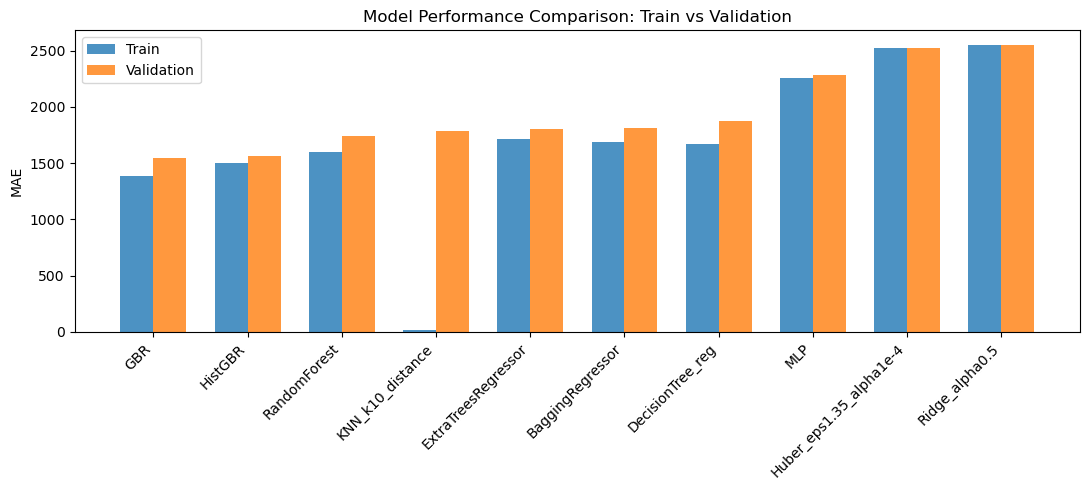

In [70]:
# Sort the DataFrame by the Mean Absolute Error (MAE) on the validation set.
# This ensures the best-performing models (lowest MAE_val) are plotted first.
df_plot = results_df.sort_values("mae_val")

x = np.arange(len(df_plot))  # Define the base positions (indices) for each model on the X-axis.
width = 0.35                 # Define the width for each individual bar in the grouped chart.

plt.figure(figsize=(11, 5)) 

# Plot the bars for the Training MAE.
plt.bar(
    # Shift position to the left (by half the width) to group with validation bars.
    x - width/2,
    # Use 'mae_train' column values for the height of the bars.
    df_plot["mae_train"],
    width,
    label="Train",
    alpha=0.8 # Set transparency level.
)

# Plot the bars for the Validation MAE.
plt.bar(
    # Shift position to the right (by half the width) to group with train bars.
    x + width/2,
    # Use 'mae_val' column values for the height of the bars.
    df_plot["mae_val"],
    width,
    label="Validation",
    alpha=0.8
)

# Set the X-axis tick marks to the model names.
plt.xticks(
    x,                          # Use the numerical positions 'x' for the tick locations.
    df_plot["model"],          
    rotation=45,                
    ha="right"                  
)

plt.ylabel("MAE") 
plt.title("Model Performance Comparison: Train vs Validation")
plt.legend() 
plt.tight_layout() # Automatically adjust plot parameters to fit everything neatly (e.g., margins).
plt.show()

| **Model**      | **MAE train** | **MAE val** |  **MAE val - MAE train** | **R2 val** | **Notes** | Performance with log(price) |
|--------------------|--------------|--------------|-----------------|----------------------------|-----------------|-----------------|
| HistGBR    |  1497 | 1564 | 67 | 0.927 |Good score, and almost doesn't overfit. | Better
| GBR    |    1385 | 1544 | 159 | 0.926 | Best score but with some overfit. | Better
| Random Forest    |    1600 | 1737 | 137 | 0.884|Good score but with some overfit. | Better
| KNN (k=10) | 20 | 1787 | 1767 | 0.877 | Brutal overfit | Worse
| Extra Trees Regressor | 1712 | 1799 | 87 | 0.888 | Good score, with small overtfit.|Better
| Bagging Regressor | 1695 | 1810 | 115 | 0.876 | Worse that RF, but with less overfit (small difference)| Better
| Decision Tree | 1669 | 1873 | 207 | 0.872 | Good score but with some overfit, even with prepruning | Better
| MLP | 2206 | 2234 | 28 | 0.853 | Not the best score, might need more tunning. | Better
| Huber | 2525 | 2527 | 2 | 0.754 | Underfit | Better
| Ridge | 2551 | 2552 | 1 | 0.763 | Underfit | Better

From this intial testing, 3 models stand out, MAE (and performace) wise: **HistGBR, GBR and RandomForest**. **Gradient Boosting achieves the best MAE in validation data**, and simultaneously the smallest overfit (gap between tain and validation), being our prime candidate so far.

**Linear models** (Huber and Ridge) **underfit**, and **KNN** displays **extreme overfit**. The single **Decision Tree underperforms the majority of the tree ensembles** tested, even after some simple prepruning to control overfit. Therefore, these models will not be further tuned, will just be kept as baselines.

Additionally, all models were tested with and without log1(price) transformation, and the results revealed that MAE improved in all models, except for KNN.

<a id="3"></a>

# **6. Model Optimization**

The best models, and the ones in which we are focusing our optimization efforts, are essentially ensembles: HistGBR, GBR and Random Forest. For the search of the best feature selection method and hyperparameters (for these models), we will proceed with no scaler, as scaling doesn't affect the performance of these models.

However, we use log tranformations in `mileage` and `price`, to help center the distributions (reduce the skewness), and additionally we winsorize the extreme values in `tax`, `mileage` and `mpg` (in the quantile 99,2%), to mitigate the effects of statistical outliers in our model.

## 6.1. Feature selection strategy

To destermine which eature selection strategy is the most suitable for our 3 best performing models (HistGBR, GBR and Random Forest, the ones that achieved the lowest MAE), we compared the following options:
* **No feature seletion**: to understand whether Feature selection has a significant impact on the model performance;
* Filter method - **SelectKBest** (mutual information): with k=19, 23 and 26, to test a wide enough range of values for the number of selected variables. It ranks each feature by its mutual information with the target and keeps the best k features.
* **RFE with DT**: with k=23, the middle ground for the range of k considered in SelectKBest.
* **Select from model with RF**: defines the variables to keep according to a treshold of "median", which means that we keep the variables with importance (based on impurity) above the median.


In [72]:
models_core = [
    ("GBR_base", GradientBoostingRegressor(
            random_state=42,
            learning_rate=0.05,
            max_depth=8,      
    )),

    ("RF_base", RandomForestRegressor(
            n_estimators=300,
            max_depth=15,
            min_samples_split = 40,
            min_samples_leaf = 20,
            random_state=42,
            n_jobs=-1
    )),

    ("HistGBR_base", HistGradientBoostingRegressor(
                    random_state=42,
                    learning_rate=0.05,
                    max_iter=300,
                    max_depth=8,
    ))
]

fs_strategies = {
    "Without Feature selection": None,

    "kbest_19": SelectKBest(score_func=lambda X, y: mutual_info_regression(X, y, random_state=42), k=19),
    "kbest_23": SelectKBest(score_func=lambda X, y: mutual_info_regression(X, y, random_state=42), k=23),
    "kbest_26": SelectKBest(score_func=lambda X, y: mutual_info_regression(X, y, random_state=42), k=26),

    "rfe_DT_23": RFE(
        estimator=DecisionTreeRegressor(
                    max_depth=8,
                    min_samples_leaf=20,
                    random_state=42),
        n_features_to_select=23,
        step=0.2
    ),

    "rf_sfm": SelectFromModel(
         RandomForestRegressor(
             n_estimators=200,
             max_depth=10,
             random_state=42,
             n_jobs=-1
         ),
         threshold="median"
    ),
}

results_fs = []
for model_name, model in models_core:
  for fs_name, selector in fs_strategies.items():
      print(f"\n=== {model_name} + {fs_name} ===")

      summary, sel_freq = avg_scores(
            kf,
            X_train_val, y_train_val,
            model= model,
            scaler=None,
            fill_method='median',
            selector=selector,
            fe_freq_cols=('model',),
            ohe_cols=('fuelType', 'transmission', 'Brand'),
            use_log_target=True,
            clip_cols=('mileage','tax', 'mpg'),
            clip_quantile=0.992
      )

      mae_tr = summary.loc["MAE", "Train"]
      mae_va = summary.loc["MAE", "Validation"]

      results_fs.append({
            "model": model_name,
            "fs_strategy": fs_name,
            "mae_train": mae_tr,
            "mae_val": mae_va,
            "gap": mae_va - mae_tr
        })


=== GBR_base + Without Feature selection ===
Nº features after preprocessing: 29
Without feature selection (selector=None).

=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9510      0.9270
MAE     1377.5540   1538.5896
R2         0.9510      0.9271
RMSE    2154.9886   2625.6865

=== GBR_base + kbest_19 ===
Nº features after preprocessing: 29
Nº features after feature selection: 19

=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9493      0.9253
MAE     1405.0847   1567.2459
R2         0.9493      0.9254
RMSE    2191.9812   2656.1709

=== Feature Selection frequency (proportion of folds) ===
tax                            1.0
mpg                            1.0
engineSize                     1.0
car_age                        1.0
mileage_per_year               1.0
is_high_end                    1.0
engine_per_litre_efficiency    1.0
model_freq                     1.0
fuelType_diesel                1.0
fuelType_petrol                1.0

In [73]:
fs_df = (
    pd.DataFrame(results_fs)
    .sort_values(["model","mae_val"])
    .reset_index(drop=True)
)
display(fs_df)

model                fs_strategy    mae_train      mae_val  \
0       GBR_base  Without Feature selection  1377.553967  1538.589636   
1       GBR_base                  rfe_DT_23  1381.288529  1540.263130   
2       GBR_base                   kbest_26  1384.937266  1543.978408   
3       GBR_base                   kbest_23  1384.308804  1544.177156   
4       GBR_base                     rf_sfm  1404.726109  1564.403647   
5       GBR_base                   kbest_19  1405.084710  1567.245884   
6   HistGBR_base  Without Feature selection  1488.503053  1557.878404   
7   HistGBR_base                  rfe_DT_23  1493.610068  1561.274483   
8   HistGBR_base                   kbest_23  1496.764717  1563.815503   
9   HistGBR_base                   kbest_26  1497.287266  1565.442824   
10  HistGBR_base                   kbest_19  1506.112292  1575.258478   
11  HistGBR_base                     rf_sfm  1519.088812  1588.138851   
12       RF_base  Without Feature selection  1597.573587  1736.988087   
13       RF_base                   kbest_26  1599.185513  1737.002284   
14       RF_base                   kbest_23  1600.332727  1737.121119   
15       RF_base                  rfe_DT_23  1601.229356  1737.341188   
16       RF_base                   kbest_19  1611.113229  1749.273436   
17       RF_base                     rf_sfm  1616.373372  1752.404875   

           gap  
0   161.035669  
1   158.974601  
2   159.041143  
3   159.868352  
4   159.677538  
5   162.161175  
6    69.375351  
7    67.664415  
8    67.050786  
9    68.155558  
10   69.146186  
11   69.050039  
12  139.414501  
13  137.816771  
14  136.788392  
15  136.111831  
16  138.160207  
17  136.031502

In [ ]:
plt.figure(figsize=(14, 8))
sns.barplot(
    data=fs_df, 
    x='model', 
    y='mae_val', 
    hue='fs_strategy', 
    palette='viridis' 
)

plt.title('Validation MAE Grouped by Model (Colors: FS Strategy)', fontsize=16)
plt.xlabel('Model (GBR, RF, HistGBR)', fontsize=12)
plt.ylabel('Validation MAE', fontsize=12)
plt.xticks(rotation=0) 
plt.legend(title='Feature Selection Strategy (FS)', bbox_to_anchor=(1.05, 1), loc=2)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(14, 8))
sns.barplot(
    data=fs_df, 
    x='fs_strategy', 
    y='mae_val', 
    hue='model', 
    palette='viridis'
)

plt.title('Comparison of Validation Mean Absolute Error (MAE) by Model and FS Strategy', fontsize=16)
plt.xlabel('Feature Selection Strategy (FS)', fontsize=12)
plt.ylabel('Validation MAE', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The following points summarize the conclusions we can draw from these tests:
* GBR achieves the best MAE in validation with **no feature selection** (1538 vs 1540 with SelectKBest), so we keep the full feature set for this model;
*  for the HistGBR model (with the baseline parameters and no scaler), the method that leads to the best MAE is **SelectKBest with k=26**.
* the Random Forest reports the same preference as the HistGBR.

However, we should take this with a grain of salt - overall, feature selection has only a modest impact on performance: for all three models the spread in validation MAE across strategies is around 1–2%.

In conclusion, we treated feature selection as a model-dependent design choice, and therefore we will move foward using **no feature selection in GBR and SelectKbest with k=26 for HistGBR and Random Forest**, as it shows to be robust and maximizes performance.

## 6.2. Random search

In [ ]:
def sample_params(space):
    params = {}
    for name, values in space.items():
        if isinstance(values, tuple):
            low, high = values # for continuous intervals
            params[name] = float(np.random.uniform(low, high))
        elif isinstance(values, list): # for lists with specific values (or integers)
            params[name] = random.choice(values)
        else:
            raise ValueError(f"Invalid space for {name}")
    return params

# selector to use in HistGBR and Random Forest (determined in 6.1.)
base_selector= SelectKBest(score_func=mutual_info_regression, k=26)

# k-fold instance used previously with 3 folds
base_kf = kf

### 6.2.1. HistGBR

To optimize this model, we set the baseline for comparison: Hist GBR with the initial parameters, no scaler and SelectKBest with k=26 (determined in 6.1. Feature selection optimization). All other preprocessing steps are the same used in 5.2. Benchmark, where we defined the common pipeline for preprocessing.

In [75]:
# same parameters we used in 5.2. Models_to_try "HistGBR",
# but using the most appropriate feature selection technique
baseline_hgb = HistGradientBoostingRegressor(
    random_state=42,
    learning_rate=0.05,
    max_iter=300,
    max_depth=8,
)

summary_hgb_base, _ = avg_scores(
    base_kf, X_train_val, y_train_val,
    model=baseline_hgb,
    scaler=None,
    fill_method='median',
    selector=base_selector,
    fe_freq_cols=('model','Brand'),
    ohe_cols=('fuelType','transmission'),
    use_log_target=True,
    clip_cols=('mileage','tax', 'mpg'),
    clip_quantile=0.992
)

baseline_mae_val = summary_hgb_base.loc["MAE", "Validation"]
print("\nBaseline MAE (validation):", baseline_mae_val)


c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(


Nº features after preprocessing: 20
Nº features after feature selection: 20


c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(
c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(



=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9374      0.9271
MAE     1490.1035   1560.5625
R2         0.9375      0.9272
RMSE    2434.8146   2627.5956

=== Feature Selection frequency (proportion of folds) ===
tax                            1.0
mpg                            1.0
engineSize                     1.0
previousOwners                 1.0
car_age                        1.0
mileage_per_year               1.0
is_high_end                    1.0
engine_per_litre_efficiency    1.0
model_freq                     1.0
Brand_freq                     1.0
fuelType_diesel                1.0
fuelType_electric              1.0
fuelType_hybrid                1.0
fuelType_other                 1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_other             1.0
transmission_semi-automatic    1.0
log_mileage                    1.0
dtype: float64

Baseline MAE (validation): 1560.562545017749

Defining the hyperparameter search space, and a function that defines a random combination of them, that will be called in each iteration (each iteration will use a random combination of hyperparameters defined in the search space).

In [76]:
# fixing seeds for random search
np.random.seed(42)
random.seed(42)

# Hyperparameter space for HistGradientBoostingRegressor
param_space_hgb = {
    "loss": ['squared_error', 'absolute_error'],
    "learning_rate": (0.05, 0.2),          # continuous
    "max_depth": [6, 8, 10, 12],
    "max_iter": [100, 200, 300, 400, 500],            # number of iterations
    "min_samples_leaf": [25, 35, 40, 50],       # regularization
    "l2_regularization": (0.1, 1.0),        # Continuous
    "max_leaf_nodes": [None, 31, 63, 127],   # max number of leafs
    "max_features": [0.8, 1.0]
}

In [77]:
n_iter = 25
search_results = []

for i in range(n_iter):
    params = sample_params(param_space_hgb)

    print(f"\n>>> Iteração {i+1}/{n_iter}")
    print("Params:", params)

    model = HistGradientBoostingRegressor(
        random_state=42,
        **params
    )

    summary, _ = avg_scores(
        base_kf,
        X_train_val, y_train_val,
        model=model,
        scaler=None,
        fill_method='median',
        selector=base_selector,
        fe_freq_cols=('model', 'Brand'),
        ohe_cols=('fuelType','transmission'),
        use_log_target=True,
        clip_cols=('mileage', 'tax', 'mpg'),
        clip_quantile=0.992
    )

    mae_train = summary.loc["MAE", "Train"]
    mae_val   = summary.loc["MAE", "Validation"]

    search_results.append({
        "iter": i,
        **params,
        "mae_train": mae_train,
        "mae_val": mae_val,
        "gap": mae_val - mae_train
    })

# will print the summary of each iteration, beacuse of avg_scores function; we will summarize the results
# in search_results (the top 10 configurations of parameters out of the 25 tried)


>>> Iteração 1/25
Params: {'loss': 'squared_error', 'learning_rate': 0.10618101782710439, 'max_depth': 6, 'max_iter': 300, 'min_samples_leaf': 35, 'l2_regularization': 0.9556428757689246, 'max_leaf_nodes': 31, 'max_features': 0.8}


c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(


Nº features after preprocessing: 20
Nº features after feature selection: 20


c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(
c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(



=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9473      0.9350
MAE     1363.4005   1459.3137
R2         0.9473      0.9350
RMSE    2234.8539   2481.7207

=== Feature Selection frequency (proportion of folds) ===
tax                            1.0
mpg                            1.0
engineSize                     1.0
previousOwners                 1.0
car_age                        1.0
mileage_per_year               1.0
is_high_end                    1.0
engine_per_litre_efficiency    1.0
model_freq                     1.0
Brand_freq                     1.0
fuelType_diesel                1.0
fuelType_electric              1.0
fuelType_hybrid                1.0
fuelType_other                 1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_other             1.0
transmission_semi-automatic    1.0
log_mileage                    1.0
dtype: float64

>>> Iteração 2/25
Params: {'loss': 'squared_

c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(


Nº features after preprocessing: 20
Nº features after feature selection: 20


c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(
c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(



=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9529      0.9380
MAE     1282.3439   1411.1560
R2         0.9530      0.9380
RMSE    2111.5853   2422.7937

=== Feature Selection frequency (proportion of folds) ===
tax                            1.0
mpg                            1.0
engineSize                     1.0
previousOwners                 1.0
car_age                        1.0
mileage_per_year               1.0
is_high_end                    1.0
engine_per_litre_efficiency    1.0
model_freq                     1.0
Brand_freq                     1.0
fuelType_diesel                1.0
fuelType_electric              1.0
fuelType_hybrid                1.0
fuelType_other                 1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_other             1.0
transmission_semi-automatic    1.0
log_mileage                    1.0
dtype: float64

>>> Iteração 3/25
Params: {'loss': 'squared_

c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(


Nº features after preprocessing: 20
Nº features after feature selection: 20


c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(
c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(



=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9342      0.9249
MAE     1520.4745   1585.8027
R2         0.9343      0.9250
RMSE    2496.1963   2665.9411

=== Feature Selection frequency (proportion of folds) ===
tax                            1.0
mpg                            1.0
engineSize                     1.0
previousOwners                 1.0
car_age                        1.0
mileage_per_year               1.0
is_high_end                    1.0
engine_per_litre_efficiency    1.0
model_freq                     1.0
Brand_freq                     1.0
fuelType_diesel                1.0
fuelType_electric              1.0
fuelType_hybrid                1.0
fuelType_other                 1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_other             1.0
transmission_semi-automatic    1.0
log_mileage                    1.0
dtype: float64

>>> Iteração 4/25
Params: {'loss': 'squared_

c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(


Nº features after preprocessing: 20
Nº features after feature selection: 20


c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(
c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(



=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9676      0.9416
MAE     1052.6566   1347.8763
R2         0.9676      0.9417
RMSE    1746.4853   2350.3579

=== Feature Selection frequency (proportion of folds) ===
tax                            1.0
mpg                            1.0
engineSize                     1.0
previousOwners                 1.0
car_age                        1.0
mileage_per_year               1.0
is_high_end                    1.0
engine_per_litre_efficiency    1.0
model_freq                     1.0
Brand_freq                     1.0
fuelType_diesel                1.0
fuelType_electric              1.0
fuelType_hybrid                1.0
fuelType_other                 1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_other             1.0
transmission_semi-automatic    1.0
log_mileage                    1.0
dtype: float64

>>> Iteração 5/25
Params: {'loss': 'absolute

c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(


Nº features after preprocessing: 20
Nº features after feature selection: 20


c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(
c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(



=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9464      0.9342
MAE     1230.1082   1403.0208
R2         0.9465      0.9342
RMSE    2252.9183   2495.9635

=== Feature Selection frequency (proportion of folds) ===
tax                            1.0
mpg                            1.0
engineSize                     1.0
previousOwners                 1.0
car_age                        1.0
mileage_per_year               1.0
is_high_end                    1.0
engine_per_litre_efficiency    1.0
model_freq                     1.0
Brand_freq                     1.0
fuelType_diesel                1.0
fuelType_electric              1.0
fuelType_hybrid                1.0
fuelType_other                 1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_other             1.0
transmission_semi-automatic    1.0
log_mileage                    1.0
dtype: float64

>>> Iteração 6/25
Params: {'loss': 'squared_

c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(


Nº features after preprocessing: 20
Nº features after feature selection: 20


c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(
c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(



=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9548      0.9378
MAE     1266.4116   1412.8302
R2         0.9549      0.9378
RMSE    2068.2502   2427.3130

=== Feature Selection frequency (proportion of folds) ===
tax                            1.0
mpg                            1.0
engineSize                     1.0
previousOwners                 1.0
car_age                        1.0
mileage_per_year               1.0
is_high_end                    1.0
engine_per_litre_efficiency    1.0
model_freq                     1.0
Brand_freq                     1.0
fuelType_diesel                1.0
fuelType_electric              1.0
fuelType_hybrid                1.0
fuelType_other                 1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_other             1.0
transmission_semi-automatic    1.0
log_mileage                    1.0
dtype: float64

>>> Iteração 7/25
Params: {'loss': 'absolute

c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(


Nº features after preprocessing: 20
Nº features after feature selection: 20


c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(
c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(



=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9378      0.9272
MAE     1338.1114   1462.8512
R2         0.9378      0.9272
RMSE    2428.3041   2625.3231

=== Feature Selection frequency (proportion of folds) ===
tax                            1.0
mpg                            1.0
engineSize                     1.0
previousOwners                 1.0
car_age                        1.0
mileage_per_year               1.0
is_high_end                    1.0
engine_per_litre_efficiency    1.0
model_freq                     1.0
Brand_freq                     1.0
fuelType_diesel                1.0
fuelType_electric              1.0
fuelType_hybrid                1.0
fuelType_other                 1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_other             1.0
transmission_semi-automatic    1.0
log_mileage                    1.0
dtype: float64

>>> Iteração 8/25
Params: {'loss': 'absolute

c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(


Nº features after preprocessing: 20
Nº features after feature selection: 20


c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(
c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(



=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9519      0.9342
MAE     1092.3306   1370.3150
R2         0.9519      0.9342
RMSE    2134.7010   2496.3778

=== Feature Selection frequency (proportion of folds) ===
tax                            1.0
mpg                            1.0
engineSize                     1.0
previousOwners                 1.0
car_age                        1.0
mileage_per_year               1.0
is_high_end                    1.0
engine_per_litre_efficiency    1.0
model_freq                     1.0
Brand_freq                     1.0
fuelType_diesel                1.0
fuelType_electric              1.0
fuelType_hybrid                1.0
fuelType_other                 1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_other             1.0
transmission_semi-automatic    1.0
log_mileage                    1.0
dtype: float64

>>> Iteração 9/25
Params: {'loss': 'squared_

c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(


Nº features after preprocessing: 20
Nº features after feature selection: 20


c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(
c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(



=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9422      0.9240
MAE     1350.6449   1507.0406
R2         0.9422      0.9240
RMSE    2340.3885   2681.2934

=== Feature Selection frequency (proportion of folds) ===
tax                            1.0
mpg                            1.0
engineSize                     1.0
previousOwners                 1.0
car_age                        1.0
mileage_per_year               1.0
is_high_end                    1.0
engine_per_litre_efficiency    1.0
model_freq                     1.0
Brand_freq                     1.0
fuelType_diesel                1.0
fuelType_electric              1.0
fuelType_hybrid                1.0
fuelType_other                 1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_other             1.0
transmission_semi-automatic    1.0
log_mileage                    1.0
dtype: float64

>>> Iteração 10/25
Params: {'loss': 'absolut

c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(


Nº features after preprocessing: 20
Nº features after feature selection: 20


c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(
c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(



=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9444      0.9322
MAE     1225.4953   1396.3824
R2         0.9444      0.9323
RMSE    2295.2264   2531.9387

=== Feature Selection frequency (proportion of folds) ===
tax                            1.0
mpg                            1.0
engineSize                     1.0
previousOwners                 1.0
car_age                        1.0
mileage_per_year               1.0
is_high_end                    1.0
engine_per_litre_efficiency    1.0
model_freq                     1.0
Brand_freq                     1.0
fuelType_diesel                1.0
fuelType_electric              1.0
fuelType_hybrid                1.0
fuelType_other                 1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_other             1.0
transmission_semi-automatic    1.0
log_mileage                    1.0
dtype: float64

>>> Iteração 11/25
Params: {'loss': 'squared

c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(


Nº features after preprocessing: 20
Nº features after feature selection: 20


c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(
c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(



=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9321      0.9239
MAE     1525.4887   1584.8302
R2         0.9321      0.9239
RMSE    2537.2857   2684.8892

=== Feature Selection frequency (proportion of folds) ===
tax                            1.0
mpg                            1.0
engineSize                     1.0
previousOwners                 1.0
car_age                        1.0
mileage_per_year               1.0
is_high_end                    1.0
engine_per_litre_efficiency    1.0
model_freq                     1.0
Brand_freq                     1.0
fuelType_diesel                1.0
fuelType_electric              1.0
fuelType_hybrid                1.0
fuelType_other                 1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_other             1.0
transmission_semi-automatic    1.0
log_mileage                    1.0
dtype: float64

>>> Iteração 12/25
Params: {'loss': 'absolut

c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(


Nº features after preprocessing: 20
Nº features after feature selection: 20


c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(
c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(



=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9510      0.9357
MAE     1140.1678   1378.8183
R2         0.9510      0.9357
RMSE    2155.3959   2467.7590

=== Feature Selection frequency (proportion of folds) ===
tax                            1.0
mpg                            1.0
engineSize                     1.0
previousOwners                 1.0
car_age                        1.0
mileage_per_year               1.0
is_high_end                    1.0
engine_per_litre_efficiency    1.0
model_freq                     1.0
Brand_freq                     1.0
fuelType_diesel                1.0
fuelType_electric              1.0
fuelType_hybrid                1.0
fuelType_other                 1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_other             1.0
transmission_semi-automatic    1.0
log_mileage                    1.0
dtype: float64

>>> Iteração 13/25
Params: {'loss': 'squared

c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(


Nº features after preprocessing: 20
Nº features after feature selection: 20


c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(
c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(



=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9530      0.9374
MAE     1283.4129   1418.2012
R2         0.9530      0.9375
RMSE    2109.8151   2433.9516

=== Feature Selection frequency (proportion of folds) ===
tax                            1.0
mpg                            1.0
engineSize                     1.0
previousOwners                 1.0
car_age                        1.0
mileage_per_year               1.0
is_high_end                    1.0
engine_per_litre_efficiency    1.0
model_freq                     1.0
Brand_freq                     1.0
fuelType_diesel                1.0
fuelType_electric              1.0
fuelType_hybrid                1.0
fuelType_other                 1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_other             1.0
transmission_semi-automatic    1.0
log_mileage                    1.0
dtype: float64

>>> Iteração 14/25
Params: {'loss': 'squared

c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(


Nº features after preprocessing: 20
Nº features after feature selection: 20


c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(
c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(



=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9491      0.9332
MAE     1307.3766   1441.2207
R2         0.9491      0.9333
RMSE    2196.2977   2513.7941

=== Feature Selection frequency (proportion of folds) ===
tax                            1.0
mpg                            1.0
engineSize                     1.0
previousOwners                 1.0
car_age                        1.0
mileage_per_year               1.0
is_high_end                    1.0
engine_per_litre_efficiency    1.0
model_freq                     1.0
Brand_freq                     1.0
fuelType_diesel                1.0
fuelType_electric              1.0
fuelType_hybrid                1.0
fuelType_other                 1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_other             1.0
transmission_semi-automatic    1.0
log_mileage                    1.0
dtype: float64

>>> Iteração 15/25
Params: {'loss': 'squared

c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(


Nº features after preprocessing: 20
Nº features after feature selection: 20


c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(
c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(



=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9612      0.9412
MAE     1172.5619   1371.2498
R2         0.9612      0.9413
RMSE    1917.0004   2358.6161

=== Feature Selection frequency (proportion of folds) ===
tax                            1.0
mpg                            1.0
engineSize                     1.0
previousOwners                 1.0
car_age                        1.0
mileage_per_year               1.0
is_high_end                    1.0
engine_per_litre_efficiency    1.0
model_freq                     1.0
Brand_freq                     1.0
fuelType_diesel                1.0
fuelType_electric              1.0
fuelType_hybrid                1.0
fuelType_other                 1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_other             1.0
transmission_semi-automatic    1.0
log_mileage                    1.0
dtype: float64

>>> Iteração 16/25
Params: {'loss': 'absolut

c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(


Nº features after preprocessing: 20
Nº features after feature selection: 20


c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(
c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(



=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9465      0.9326
MAE     1187.6474   1392.8993
R2         0.9465      0.9326
RMSE    2252.0401   2525.8611

=== Feature Selection frequency (proportion of folds) ===
tax                            1.0
mpg                            1.0
engineSize                     1.0
previousOwners                 1.0
car_age                        1.0
mileage_per_year               1.0
is_high_end                    1.0
engine_per_litre_efficiency    1.0
model_freq                     1.0
Brand_freq                     1.0
fuelType_diesel                1.0
fuelType_electric              1.0
fuelType_hybrid                1.0
fuelType_other                 1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_other             1.0
transmission_semi-automatic    1.0
log_mileage                    1.0
dtype: float64

>>> Iteração 17/25
Params: {'loss': 'squared

c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(


Nº features after preprocessing: 20
Nº features after feature selection: 20


c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(
c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(



=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9323      0.9220
MAE     1533.0853   1605.7094
R2         0.9323      0.9221
RMSE    2533.5090   2717.3099

=== Feature Selection frequency (proportion of folds) ===
tax                            1.0
mpg                            1.0
engineSize                     1.0
previousOwners                 1.0
car_age                        1.0
mileage_per_year               1.0
is_high_end                    1.0
engine_per_litre_efficiency    1.0
model_freq                     1.0
Brand_freq                     1.0
fuelType_diesel                1.0
fuelType_electric              1.0
fuelType_hybrid                1.0
fuelType_other                 1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_other             1.0
transmission_semi-automatic    1.0
log_mileage                    1.0
dtype: float64

>>> Iteração 18/25
Params: {'loss': 'absolut

c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(


Nº features after preprocessing: 20
Nº features after feature selection: 20


c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(
c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(



=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9395      0.9288
MAE     1249.6104   1405.8466
R2         0.9395      0.9289
RMSE    2394.0294   2594.4548

=== Feature Selection frequency (proportion of folds) ===
tax                            1.0
mpg                            1.0
engineSize                     1.0
previousOwners                 1.0
car_age                        1.0
mileage_per_year               1.0
is_high_end                    1.0
engine_per_litre_efficiency    1.0
model_freq                     1.0
Brand_freq                     1.0
fuelType_diesel                1.0
fuelType_electric              1.0
fuelType_hybrid                1.0
fuelType_other                 1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_other             1.0
transmission_semi-automatic    1.0
log_mileage                    1.0
dtype: float64

>>> Iteração 19/25
Params: {'loss': 'squared

c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(


Nº features after preprocessing: 20
Nº features after feature selection: 20


c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(
c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(



=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9544      0.9375
MAE     1266.9176   1412.9956
R2         0.9544      0.9375
RMSE    2078.1996   2433.0566

=== Feature Selection frequency (proportion of folds) ===
tax                            1.0
mpg                            1.0
engineSize                     1.0
previousOwners                 1.0
car_age                        1.0
mileage_per_year               1.0
is_high_end                    1.0
engine_per_litre_efficiency    1.0
model_freq                     1.0
Brand_freq                     1.0
fuelType_diesel                1.0
fuelType_electric              1.0
fuelType_hybrid                1.0
fuelType_other                 1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_other             1.0
transmission_semi-automatic    1.0
log_mileage                    1.0
dtype: float64

>>> Iteração 20/25
Params: {'loss': 'squared

c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(


Nº features after preprocessing: 20
Nº features after feature selection: 20


c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(
c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(



=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9157      0.9096
MAE     1673.2952   1715.2519
R2         0.9158      0.9096
RMSE    2825.5539   2926.3171

=== Feature Selection frequency (proportion of folds) ===
tax                            1.0
mpg                            1.0
engineSize                     1.0
previousOwners                 1.0
car_age                        1.0
mileage_per_year               1.0
is_high_end                    1.0
engine_per_litre_efficiency    1.0
model_freq                     1.0
Brand_freq                     1.0
fuelType_diesel                1.0
fuelType_electric              1.0
fuelType_hybrid                1.0
fuelType_other                 1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_other             1.0
transmission_semi-automatic    1.0
log_mileage                    1.0
dtype: float64

>>> Iteração 21/25
Params: {'loss': 'absolut

c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(


Nº features after preprocessing: 20
Nº features after feature selection: 20


c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(
c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(



=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9198      0.9144
MAE     1511.7264   1580.9585
R2         0.9198      0.9144
RMSE    2756.4959   2846.2691

=== Feature Selection frequency (proportion of folds) ===
tax                            1.0
mpg                            1.0
engineSize                     1.0
previousOwners                 1.0
car_age                        1.0
mileage_per_year               1.0
is_high_end                    1.0
engine_per_litre_efficiency    1.0
model_freq                     1.0
Brand_freq                     1.0
fuelType_diesel                1.0
fuelType_electric              1.0
fuelType_hybrid                1.0
fuelType_other                 1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_other             1.0
transmission_semi-automatic    1.0
log_mileage                    1.0
dtype: float64

>>> Iteração 22/25
Params: {'loss': 'absolut

c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(


Nº features after preprocessing: 20
Nº features after feature selection: 20


c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(
c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(



=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9236      0.9162
MAE     1443.8512   1534.4633
R2         0.9237      0.9162
RMSE    2690.0947   2816.1503

=== Feature Selection frequency (proportion of folds) ===
tax                            1.0
mpg                            1.0
engineSize                     1.0
previousOwners                 1.0
car_age                        1.0
mileage_per_year               1.0
is_high_end                    1.0
engine_per_litre_efficiency    1.0
model_freq                     1.0
Brand_freq                     1.0
fuelType_diesel                1.0
fuelType_electric              1.0
fuelType_hybrid                1.0
fuelType_other                 1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_other             1.0
transmission_semi-automatic    1.0
log_mileage                    1.0
dtype: float64

>>> Iteração 23/25
Params: {'loss': 'squared

c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(


Nº features after preprocessing: 20
Nº features after feature selection: 20


c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(
c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(



=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9426      0.9290
MAE     1420.6773   1519.8570
R2         0.9426      0.9290
RMSE    2331.8578   2593.5035

=== Feature Selection frequency (proportion of folds) ===
tax                            1.0
mpg                            1.0
engineSize                     1.0
previousOwners                 1.0
car_age                        1.0
mileage_per_year               1.0
is_high_end                    1.0
engine_per_litre_efficiency    1.0
model_freq                     1.0
Brand_freq                     1.0
fuelType_diesel                1.0
fuelType_electric              1.0
fuelType_hybrid                1.0
fuelType_other                 1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_other             1.0
transmission_semi-automatic    1.0
log_mileage                    1.0
dtype: float64

>>> Iteração 24/25
Params: {'loss': 'squared

c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(


Nº features after preprocessing: 20
Nº features after feature selection: 20


c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(
c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(



=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9490      0.9360
MAE     1333.0389   1442.3600
R2         0.9490      0.9360
RMSE    2198.0576   2461.6298

=== Feature Selection frequency (proportion of folds) ===
tax                            1.0
mpg                            1.0
engineSize                     1.0
previousOwners                 1.0
car_age                        1.0
mileage_per_year               1.0
is_high_end                    1.0
engine_per_litre_efficiency    1.0
model_freq                     1.0
Brand_freq                     1.0
fuelType_diesel                1.0
fuelType_electric              1.0
fuelType_hybrid                1.0
fuelType_other                 1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_other             1.0
transmission_semi-automatic    1.0
log_mileage                    1.0
dtype: float64

>>> Iteração 25/25
Params: {'loss': 'absolut

c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(


Nº features after preprocessing: 20
Nº features after feature selection: 20


c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(
c:\Users\guilh\anaconda3\envs\Fall2526\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:782: UserWarning: k=26 is greater than n_features=20. All the features will be returned.
  warnings.warn(



=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9485      0.9350
MAE     1196.4147   1382.8242
R2         0.9485      0.9350
RMSE    2209.0657   2480.2599

=== Feature Selection frequency (proportion of folds) ===
tax                            1.0
mpg                            1.0
engineSize                     1.0
previousOwners                 1.0
car_age                        1.0
mileage_per_year               1.0
is_high_end                    1.0
engine_per_litre_efficiency    1.0
model_freq                     1.0
Brand_freq                     1.0
fuelType_diesel                1.0
fuelType_electric              1.0
fuelType_hybrid                1.0
fuelType_other                 1.0
fuelType_petrol                1.0
transmission_automatic         1.0
transmission_manual            1.0
transmission_other             1.0
transmission_semi-automatic    1.0
log_mileage                    1.0
dtype: float64


In [ ]:
search_df = pd.DataFrame(search_results).sort_values("mae_val").reset_index(drop=True)

print("\n=== Top 10 configurations by validation MAE ===")
display(search_df.head(10))

best_row_hgb = search_df.iloc[0]

def to_int_or_none(x):
    return None if pd.isna(x) else int(x)

best_params = {
    "learning_rate":     float(best_row_hgb["learning_rate"]),
    "max_depth":         to_int_or_none(best_row_hgb["max_depth"]),
    "max_iter":          int(best_row_hgb["max_iter"]),
    "min_samples_leaf":  int(best_row_hgb["min_samples_leaf"]),
    "l2_regularization": float(best_row_hgb["l2_regularization"]),
    "max_leaf_nodes":    to_int_or_none(best_row_hgb["max_leaf_nodes"]),
}

print("\n Best configuration found:")
print(best_params)
print("MAE train:", best_row_hgb["mae_train"])
print("MAE val:  ", best_row_hgb["mae_val"])
print("Baseline MAE val:", baseline_mae_val)


=== Top 10 configurações por MAE de validação ===


iter            loss  learning_rate  max_depth  max_iter  min_samples_leaf  \
0     3   squared_error       0.085480         12       500                40   
1     7  absolute_error       0.093869         10       500                35   
2    14   squared_error       0.184607         10       200                35   
3    11  absolute_error       0.192239         12       300                35   
4    24  absolute_error       0.088837          8       500                35   
5    15  absolute_error       0.118783         10       200                35   
6     9  absolute_error       0.088996         12       300                35   
7     4  absolute_error       0.199670         10       300                35   
8    17  absolute_error       0.050383         12       500                50   
9     1   squared_error       0.092031          6       500                50   

   l2_regularization  max_leaf_nodes  max_features    mae_train      mae_val  \
0           0.936026             NaN           0.8  1052.656599  1347.876271   
1           0.462246             NaN           0.8  1092.330558  1370.314954   
2           0.578149            63.0           1.0  1172.561940  1371.249762   
3           0.226857            63.0           0.8  1140.167755  1378.818287   
4           0.557394            63.0           1.0  1196.414698  1382.824156   
5           0.780265           127.0           0.8  1187.647444  1392.899338   
6           0.203961            63.0           1.0  1225.495327  1396.382362   
7           0.769059            31.0           1.0  1230.108161  1403.020848   
8           0.330074            63.0           0.8  1249.610428  1405.846582   
9           0.241701             NaN           0.8  1282.343869  1411.155969   

          gap  
0  295.219672  
1  277.984396  
2  198.687822  
3  238.650532  
4  186.409458  
5  205.251894  
6  170.887035  
7  172.912687  
8  156.236155  
9  128.812101


Melhor configuração encontrada:
{'learning_rate': 0.08547963356786546, 'max_depth': 12, 'max_iter': 500, 'min_samples_leaf': 40, 'l2_regularization': 0.9360260523737787, 'max_leaf_nodes': None}
MAE train: 1052.6565991918199
MAE val:   1347.8762708543309
Baseline MAE val: 1560.5625450177492


### 6.2.2. GBR

To optimize this model, we set the baseline for comparison: GBR with the initial parameters, no scaler and no feature selection (determined in 6.1. Feature selection optimization). All other preprocessing steps are the same used in 5.2. Benchmark, where we defined the common pipeline for preprocessing.

In [79]:
# same parameters we used in 5.2. Models_to_try "GBR"
baseline_gbr = GradientBoostingRegressor(
            random_state=42,
            learning_rate=0.05,
            max_depth=8,
        )

summary_gb_base, _ = avg_scores(
    base_kf, X_train_val, y_train_val,
    model=baseline_gbr,
    scaler=None,
    fill_method='median',
    selector= None,
    fe_freq_cols=('model',),
    ohe_cols=('fuelType','transmission','Brand'),
    use_log_target=True,
    clip_cols=('mileage','tax', 'mpg'),
    clip_quantile=0.992
)

print("\n=== Baseline GradientBoostingRegressor ===")
print(summary_gb_base)

baseline_mae_val_gb = summary_gb_base.loc["MAE", "Validation"]
print("\nBaseline MAE (validation):", baseline_mae_val_gb)

Nº features after preprocessing: 29
Without feature selection (selector=None).

=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9510      0.9270
MAE     1377.5540   1538.5896
R2         0.9510      0.9271
RMSE    2154.9886   2625.6865

=== Baseline GradientBoostingRegressor ===
              Train   Validation
Adj_R2     0.950982     0.926993
MAE     1377.553967  1538.589636
R2         0.951010     0.927077
RMSE    2154.988552  2625.686463

Baseline MAE (validation): 1538.5896360260524


In [ ]:
# fixing seeds for random search
np.random.seed(42)
random.seed(42)

# Hyperparameter space for GradientBoostingRegressor
param_space_gbr = {
    #"loss": ["squared_error", "absolute_error", "quantile"],
    "learning_rate": (0.05, 0.15),          # continuous
    "max_depth": [4, 6, 8, 10],
    "n_estimators": [100, 200, 300, 400,500],
    "min_samples_leaf": [15, 20, 35 ,50],
    "min_samples_split": [30, 40, 60],
    "max_leaf_nodes": [None, 31, 63, 127],   # maximum number of leafs
    "subsample": [0.85, 1.0],
    "max_features": [0.8, 1.0]
}

In [82]:
n_iter = 25
search_results_gbr = []

for i in range(n_iter):
    params = sample_params(param_space_gbr)

    print(f"\n>>> Iteration {i+1}/{n_iter}")
    print("Params:", params)

    model = GradientBoostingRegressor(
        random_state=42,
        **params
    )

    summary_gbr, _ = avg_scores(
        base_kf,
        X_train_val, y_train_val,
        model=model,
        scaler=None,
        fill_method='median',
        selector=None,
        fe_freq_cols=('model',),
        ohe_cols=('fuelType','transmission','Brand'),
        use_log_target=True,
        clip_cols=('mileage', 'tax', 'mpg'),
        clip_quantile=0.992
    )

    mae_train = summary_gbr.loc["MAE", "Train"]
    mae_val   = summary_gbr.loc["MAE", "Validation"]

    search_results_gbr.append({
        "iter": i,
        **params,
        "mae_train": mae_train,
        "mae_val": mae_val,
        "gap": mae_val - mae_train
    })



>>> Iteration 1/25
Params: {'learning_rate': 0.1469909852161994, 'max_depth': 6, 'n_estimators': 100, 'min_samples_leaf': 35, 'min_samples_split': 40, 'max_leaf_nodes': 63, 'subsample': 0.85, 'max_features': 0.8}
Nº features after preprocessing: 29
Without feature selection (selector=None).

=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9351      0.9237
MAE     1506.9482   1585.7389
R2         0.9351      0.9238
RMSE    2480.0580   2687.2692

>>> Iteration 2/25
Params: {'learning_rate': 0.13324426408004217, 'max_depth': 8, 'n_estimators': 200, 'min_samples_leaf': 50, 'min_samples_split': 40, 'max_leaf_nodes': 127, 'subsample': 0.85, 'max_features': 1.0}
Nº features after preprocessing: 29
Without feature selection (selector=None).

=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9523      0.9356
MAE     1282.5847   1431.1292
R2         0.9523      0.9357
RMSE    2125.6218   2469.0874

>>> Iteration 3/25
Params: {'learning_rate': 0.07

In [83]:
search_df = pd.DataFrame(search_results_gbr).sort_values("mae_val").reset_index(drop=True)

print("\n=== Top 10 configurations by validation MAE ===")
display(search_df.head(10))

best_row_gbr = search_df.iloc[0]

print("MAE train:", best_row_gbr["mae_train"])
print("MAE val:  ", best_row_gbr["mae_val"])


=== Top 10 configurations by validation MAE ===


iter  learning_rate  max_depth  n_estimators  min_samples_leaf  \
0    19       0.110754         10           500                15   
1    24       0.130840         10           500                20   
2    15       0.069967         10           400                20   
3     7       0.093195          8           500                20   
4    22       0.144889         10           500                50   
5    16       0.101423         10           400                50   
6     8       0.079123          8           400                15   
7    11       0.079214          8           400                35   
8    17       0.109241         10           300                15   
9     1       0.133244          8           200                50   

   min_samples_split  max_leaf_nodes  subsample  max_features    mae_train  \
0                 30             NaN       0.85           0.8   794.373970   
1                 30             NaN       0.85           0.8   824.269400   
2                 30             NaN       1.00           1.0  1008.256047   
3                 30            63.0       0.85           0.8  1110.584289   
4                 30            31.0       1.00           0.8  1166.474284   
5                 60             NaN       0.85           0.8  1125.566454   
6                 30            63.0       1.00           0.8  1165.631103   
7                 40           127.0       0.85           0.8  1205.717032   
8                 30            31.0       0.85           1.0  1290.975482   
9                 40           127.0       0.85           1.0  1282.584736   

       mae_val         gap  
0  1308.098391  513.724422  
1  1318.998521  494.729121  
2  1334.101415  325.845368  
3  1335.933959  225.349670  
4  1350.001271  183.526987  
5  1355.276014  229.709560  
6  1358.469576  192.838473  
7  1378.500239  172.783207  
8  1419.913518  128.938036  
9  1431.129161  148.544424

MAE train: 794.3739697002901
MAE val:   1308.0983912042777


### 6.2.3. Random Forest

In [84]:
# same parameters we used in 5.2. Models_to_try "Random Forest"
baseline_rf = RandomForestRegressor(
            n_estimators=300,
            max_depth=15,
            min_samples_split = 40,
            min_samples_leaf = 20,
            random_state=42,
            n_jobs=-1
        )

summary_rf_base, _ = avg_scores(
    base_kf, X_train_val, y_train_val,
    model=baseline_rf,
    scaler=None,
    fill_method='median',
    selector=base_selector,
    fe_freq_cols=('model',),
    ohe_cols=('fuelType','transmission', 'Brand'),
    use_log_target=True,
    clip_cols=('mileage','tax', 'mpg'),
    clip_quantile=0.992
)

print("\n=== Baseline Random Forest ===")
print(summary_rf_base)

baseline_mae_val_rf = summary_rf_base.loc["MAE", "Validation"]
print("\nBaseline MAE (validation):", baseline_mae_val_rf)

Nº features after preprocessing: 29
Nº features after feature selection: 26

=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.9058      0.8895
MAE     1598.2601   1736.7930
R2         0.9058      0.8896
RMSE    2987.0568   3232.4518

=== Feature Selection frequency (proportion of folds) ===
tax                            1.00
mpg                            1.00
engineSize                     1.00
car_age                        1.00
mileage_per_year               1.00
is_high_end                    1.00
engine_per_litre_efficiency    1.00
model_freq                     1.00
fuelType_diesel                1.00
fuelType_hybrid                1.00
fuelType_petrol                1.00
transmission_automatic         1.00
Brand_volkswagen               1.00
transmission_manual            1.00
transmission_semi-automatic    1.00
Brand_audi                     1.00
Brand_ford                     1.00
Brand_bmw                      1.00
Brand_hyundai                  1.00


In [ ]:
np.random.seed(42)
random.seed(42)

# Hyperparameter space for Random Forest
param_space_rf = {
    "max_depth": [12, 15, 18, 20],
    "n_estimators": [200, 300, 400,500],
    "min_samples_leaf": [10, 20, 40],
    "min_samples_split": [30, 40, 60],
    "bootstrap": [True,],
    "max_samples": [None, 0.9],
    "max_features": [0.8, 1.0],
    #"criterion": ["squared_error", "absolute_error", "friedman_mse"]
}

search_results_rf= []

for i in range(n_iter):
    params = sample_params(param_space_rf)

    print(f"\n>>> Iteração {i+1}/{n_iter}")
    print("Params:", params)

    model = RandomForestRegressor(
        random_state=42,
        **params
    )

    summary, _ = avg_scores(
        base_kf,
        X_train_val, y_train_val,
        model=model,
        scaler=None,
        fill_method='median',
        selector=None,
        fe_freq_cols=('model',),
        ohe_cols=('fuelType','transmission','Brand'),
        use_log_target=True,
        clip_cols=('mileage','tax', 'mpg'),
        clip_quantile=0.992
    )

    mae_train = summary.loc["MAE", "Train"]
    mae_val   = summary.loc["MAE", "Validation"]

    search_results_rf.append({
        "iter": i,
        **params,
        "mae_train": mae_train,
        "mae_val": mae_val
    })


>>> Iteração 1/25
Params: {'max_depth': 12, 'n_estimators': 200, 'min_samples_leaf': 40, 'min_samples_split': 40, 'bootstrap': True, 'max_samples': None, 'max_features': 0.8, 'criterion': 'friedman_mse'}
Nº features after preprocessing: 29
Without feature selection (selector=None).

=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.8835      0.8754
MAE     1839.9377   1913.4777
R2         0.8836      0.8755
RMSE    3322.0950   3433.5121

>>> Iteração 2/25
Params: {'max_depth': 12, 'n_estimators': 200, 'min_samples_leaf': 40, 'min_samples_split': 40, 'bootstrap': True, 'max_samples': None, 'max_features': 0.8, 'criterion': 'squared_error'}
Nº features after preprocessing: 29
Without feature selection (selector=None).

=== Metrics (Mean K-Fold) ===
            Train  Validation
Adj_R2     0.8835      0.8754
MAE     1839.7578   1913.4198
R2         0.8835      0.8755
RMSE    3322.3664   3433.1554

>>> Iteração 3/25
Params: {'max_depth': 15, 'n_estimators': 200, 'mi

In [ ]:
search_df_rf = pd.DataFrame(search_results_rf).sort_values("mae_val").reset_index(drop=True)

print("\n=== Top 10 configurations by validation MAE ===")
display(search_df_rf.head(10))

best_row_rf = search_df_rf.iloc[0]

print("MAE train:", best_row_rf["mae_train"])
print("MAE val:  ", best_row_rf["mae_val"])


=== Top 10 configurações por MAE de validação ===


iter  max_depth  n_estimators  min_samples_leaf  min_samples_split  \
0     9         16           400                20                 60   
1    18         12           400                15                 60   
2    21         16           200                15                 60   
3     8         10           400                15                 40   
4     3         16           300                60                 60   
5    13         12           300                60                 80   
6    20         10           300                40                 40   
7    15         12           300                20                 80   
8     7         12           400                80                 40   
9    17         16           400                80                 30   

   bootstrap  max_samples max_features    mae_train      mae_val  
0       True          NaN          0.8  1629.599338  1746.054689  
1       True          NaN          0.5  1720.715025  1817.093832  
2       True          NaN         sqrt  1811.234767  1902.150290  
3       True          0.7          0.5  1882.487264  1956.570745  
4       True          NaN          0.8  1915.354658  1975.760698  
5       True          NaN          0.5  1958.680991  2012.223669  
6       True          0.9          0.5  1977.546122  2033.630347  
7       True          NaN         sqrt  1975.599068  2038.648850  
8       True          NaN          0.8  2020.611003  2070.377652  
9       True          0.9          0.8  2026.597560  2075.716830

MAE train: 1629.5993380205446
MAE val:   1746.0546889133839


<a id="3"></a>

# **7. Final Model & Kaggle submission**

GradientBoostingRegressor(
            max_depth=12,
            max_iter=400,
            min_samples_leaf=80,
            l2_regularization=0.255633,
            learning_rate=0.149842,
            max_leaf_nodes=127,
            max_features=0.8,
            random_state=42
        ),

In [ ]:
mdl, sc, fills, sel, cat_modes, freq_maps, dummies, feat_names, sel_feat_names, clip_info = run_model(
    X_train_val, y_train_val,
    model=GradientBoostingRegressor(
            max_depth=8,
            n_estimators=500,
            min_samples_leaf=50,
            min_samples_split=80,
            subsample=1.0,
            learning_rate=0.125678,
            max_features=1.0,
            random_state=42
        ),
    fill_method='median',
    selector=SelectKBest(score_func= mutual_info_regression, k=15),
    scaler= None,
    fe_freq_cols=('model',),
    ohe_cols=('fuelType','transmission','Brand'),
    use_log_target=True,
    clip_cols=('mileage', 'tax', 'mpg'),
    clip_quantile=0.992
)

To export a csv for the kaggle submission:

In [ ]:
# ids & X_test
test_ids = test['carID'].copy().values
X_test   = test.drop(columns=['carID'], errors='ignore')


y_pred = predict_on_test(
    X_test, mdl,
    scaler=sc, fill_values=fills, selector=sel,
    cat_modes=cat_modes, freq_maps=freq_maps, dummies_cols=dummies,
    feature_names=feat_names,
    use_log_target=True, clip_info=clip_info
)


id_col = 'carID'
target_col = 'price'

# sanity checks
y_pred = np.asarray(y_pred).ravel().astype(float)
assert len(y_pred) == len(test_ids), f"len preds {len(y_pred)} != len ids {len(test_ids)}"

# export
sub = pd.DataFrame({id_col: test_ids, target_col: y_pred})
output_path = '../submissions/group66_submission.csv'
sub.to_csv(output_path, index=False)
print("submission saved to:", output_path, "->", sub.shape)

## IV. Open-Ended Section: Deployment-like interface and model interpretability

### IV.1. Objectives and rationale

The goal of the open-ended section is to **explore how our best regression pipeline could be integrated into a realistic product workflow**, while also making its behaviour more transparent.

We focused on two complementary aspects:

1. **A lightweight pricing interface for end users**  
   We implemented a simple Streamlit application that exposes the final model as an interactive tool. A user can specify car characteristics (brand, model, age, mileage, fuel type, transmission, engine size, etc.) and obtain a suggested price. This mimics how Cars4you could embed the model in a real listing-creation flow and allows us to test the model qualitatively with new, unseen combinations of features.

2. **A deeper inspection of how the model makes predictions**  
   Because our final model is a tree-based ensemble trained within a non-trivial preprocessing pipeline (log-price, winsorization, frequency encoding, feature selection), it is not obvious which variables are actually driving the predictions, and what are the ones impacting price the most. To address this, we combined:
   - **Simple impurity-based feature importances** from the final ensemble, to obtain a global ranking of the most influential features;
   - **SHAP (SHapley Additive exPlanations)** for a more detailed view, both at the global level (which features matter most on average) and at the local level (how each feature pushes individual predictions up or down).

### IV.2. Implementation outline

For the **Streamlit interface**, we reuse the trained pipeline (model + preprocessing objects) exported as a bundle. The app takes raw user inputs, applies exactly the same preprocessing steps as in our cross-validation pipeline (cleaning, encoding, clipping, scaling and feature selection), and then calls the model to generate a price prediction. This demonstrates that the model is truly “deployment-ready”: the same code used for CV can be used to score new listings.

For the **interpretability analysis**, we proceed in two steps:

- First, we compute impurity-based feature importances (when available) on the final ensemble to identify the main drivers of price (the top 10) in a simple bar chart.
- Second, we compute SHAP values on a stratified subsample of the training data (after full preprocessing), using a `TreeExplainer` on our final tree-based model. We visualise:
  - a **SHAP summary plot**, which ranks features by their average absolute SHAP value and shows how low vs high feature values affect the predicted price;
  - and several **SHAP dependence plots** for the most important variables (e.g. car age, mileage, engine size), which reveal the shape and direction of their effects on the model’s predictions.

In the next subsection, we discuss the main patterns that emerge from these analyses and how they align with economic intuition about used-car pricing.

To export the elements of preprocessing, fitted during training, for the exploration of feature importance and set up of the interface for predictions.

In [ ]:
bundle = {
    "model": mdl,
    "scaler": sc,
    "fill_values": fills,
    "selector": sel,
    "cat_modes": cat_modes,
    "freq_maps": freq_maps,
    "dummies_cols": dummies,
    "feature_names": feat_names,
    "clip_info": clip_info
}

joblib.dump(bundle, "../models/car_price_bundle.joblib")

<a id="3"></a>

# **8. Feature Importances**

In [ ]:
# 1) Retrieve the feature names used in the final model
if sel is not None and hasattr(sel, "get_support"):
    mask = sel.get_support()
    selected_feat_names = [f for f, keep in zip(feat_names, mask) if keep]
else:
    selected_feat_names = feat_names

print(f"Number of features used in the final model: {len(selected_feat_names)}")

# 2) Tree-based model feature importances (global)
importances = pd.Series(
    mdl.feature_importances_,
    index=selected_feat_names
).sort_values(ascending=False)

plt.figure(figsize=(7, 5))
importances.head(10).plot(kind='barh')
plt.gca().invert_yaxis()
plt.title("Top 10 feature importances – final model")
plt.xlabel("Feature importance (impurity-based)")
plt.tight_layout()
plt.show()

top_features_from_importance = importances.head(5).index.tolist()
print("Top features according to model.feature_importances_:", top_features_from_importance)

NameError: name 'sel' is not defined

In [ ]:
def preprocess_data_for_shap(X_raw, bundle):
    return transform_X(
        X_raw,
        scaler=bundle["scaler"],
        fill_values=bundle["fill_values"],
        selector=bundle["selector"],
        cat_modes=bundle["cat_modes"],
        freq_maps=bundle["freq_maps"],
        dummies_cols=bundle["dummies_cols"],
        feature_names=bundle["feature_names"],
        fe_freq_cols=('Brand','model'),
        ohe_cols=('fuelType','transmission'),
        clip_info=bundle["clip_info"]
    )

In [ ]:
# preprocessing train_val data, with the same steps and information as the final model
X_processed = preprocess_data_for_shap(X_train_val, bundle)

# Sampling so that SHAP becomes computationaly viable
X_sample = X_processed.sample(min(1000, len(X_processed)), random_state=42)
print(f"SHAP sample: {len(X_sample)} observations, {X_sample.shape[1]} features.")

Summary plot:

In [ ]:
mdl = bundle["model"]

# For HistGBR / RF / GBR: TreeExplainer
explainer = shap.TreeExplainer(mdl)

print("\nCalculating SHAP values...")
shap_values = explainer.shap_values(X_sample)
print("Done.")

# Summary plot global
plt.figure(figsize=(12, 9))
shap.summary_plot(
    shap_values,
    X_sample,
    show=False,
    plot_type="dot"
)
plt.title("Global feature importance – SHAP summary plot")
plt.tight_layout()
plt.show()
plt.clf()

dependence plots

In [ ]:
candidate_features = top_features_from_importance  # vindo do passo 1
top_features = [f for f in candidate_features if f in X_sample.columns][:3]

print("Features usadas nos dependence plots:", top_features)

for feature in top_features:
    print(f"\n--- SHAP dependence plot: {feature} ---")
    plt.figure(figsize=(8, 6))
    shap.dependence_plot(
        feature,
        shap_values,
        X_sample,
        dot_size=30,
        alpha=0.6,
        show=False,
        interaction_index=None
    )
    plt.title(f"Effect of '{feature}' on model prediction (SHAP)")
    plt.tight_layout()
    plt.show()
    plt.clf()